# Import packages

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import sys
sys.path.append("..")
from liver_microsome_prediction.utils import *

# Load data

In [5]:
train_data = pd.read_csv(PATH.train)
targets = ['MLM', 'HLM']
train_data

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.26,400.50,5,2,8,3.26,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.17,301.41,2,1,2,2.17,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.59,80.89,1.59,297.36,5,0,3,1.58,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC5)CC4)c3C)nn2)cc1,5.71,2.00,4.77,494.65,6,0,5,3.48,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.27,99.99,2.33,268.31,3,0,1,2.34,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.56,3.08,3.41,396.19,3,1,5,3.41,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccccc12,35.56,47.63,1.91,359.38,4,1,3,1.84,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.15,1.79,1.94,261.32,3,1,6,2.12,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.03,2.77,0.99,284.70,5,1,5,0.99,91.51


In [6]:
train_data.loc[train_data.AlogP.isna(), 'AlogP'] = train_data.AlogP.mean()

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3498 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [79]:
X  = train_data.drop(columns=targets)
ys = train_data[targets]
num_preprocessor = get_numeric_preprocessor()
num_preprocessor.fit(X)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['AlogP', 'Molecular_Weight',
                                  'Num_H_Acceptors', 'Num_H_Donors',
                                  'Num_RotatableBonds', 'LogD',
                                  'Molecular_PolarSurfaceArea'])])

In [91]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

In [92]:
base_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)
# base_model = LGBMRegressor(random_state=SEED, n_jobs=-1)
# base_model = CatBoostRegressor(random_state=SEED, n_jobs=-1)

models       = {target: [] for target in targets}
train_scores = []
val_scores   = []

for idxs_train, idxs_val in tqdm(KFold(n_splits=10, random_state=SEED, shuffle=True).split(train_data)):
    X_train, ys_train = train_data.loc[train_idxs][features], train_data.loc[train_idxs][targets]
    X_val,   ys_val   = train_data.loc[val_idxs][features],   train_data.loc[val_idxs][targets]
    
    X_train_proc = num_preprocessor.transform(X_train)
    X_val_proc   = num_preprocessor.transform(X_val)
    
    train_score, val_score = 0, 0
    for target in targets:
        y_train, y_val = ys_train[target], ys_val[target]
        model = clone(base_model).fit(X_train_proc, y_train)
        train_score += mean_squared_error(y_train, model.predict(X_train_proc), squared=False)/2
        val_score   += mean_squared_error(y_val,   model.predict(X_val_proc), squared=False)/2
        models[target].append(model)
    train_scores.append(train_score)
    val_scores.append(val_score)

print(np.mean(train_scores), train_scores)
print(np.mean(val_scores), val_scores)

10it [00:05,  1.82it/s]

12.531047178527535 [12.531047178527537, 12.531047178527537, 12.531047178527537, 12.531047178527537, 12.531047178527539, 12.531047178527537, 12.531047178527539, 12.531047178527539, 12.531047178527537, 12.531047178527537]
32.40636108198477 [32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477, 32.40636108198477]


In [93]:
# base_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)
base_model = LGBMRegressor(random_state=SEED, n_jobs=-1)
# base_model = CatBoostRegressor(random_state=SEED, n_jobs=-1)

models       = {target: [] for target in targets}
train_scores = []
val_scores   = []

for idxs_train, idxs_val in tqdm(KFold(n_splits=10, random_state=SEED, shuffle=True).split(train_data)):
    X_train, ys_train = train_data.loc[train_idxs][features], train_data.loc[train_idxs][targets]
    X_val,   ys_val   = train_data.loc[val_idxs][features],   train_data.loc[val_idxs][targets]
    
    X_train_proc = num_preprocessor.transform(X_train)
    X_val_proc   = num_preprocessor.transform(X_val)
    
    train_score, val_score = 0, 0
    for target in targets:
        y_train, y_val = ys_train[target], ys_val[target]
        model = clone(base_model).fit(X_train_proc, y_train)
        train_score += mean_squared_error(y_train, model.predict(X_train_proc), squared=False)/2
        val_score   += mean_squared_error(y_val,   model.predict(X_val_proc), squared=False)/2
        models[target].append(model)
    train_scores.append(train_score)
    val_scores.append(val_score)

print(np.mean(train_scores), train_scores)
print(np.mean(val_scores), val_scores)

0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


1it [00:04,  4.85s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


2it [00:10,  5.11s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


3it [00:14,  4.92s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


4it [00:17,  4.00s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


5it [00:20,  3.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


6it [00:24,  3.83s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


7it [00:27,  3.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


8it [00:30,  3.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


9it [00:33,  3.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 37.533758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 3148, number of used features: 7
[LightGBM] [Info] Start training from score 52.913636


10it [00:36,  3.68s/it]

23.660397695357346 [23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346, 23.660397695357346]
31.777535392455444 [31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444, 31.777535392455444]


In [89]:
# base_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)
# base_model = LGBMRegressor(random_state=SEED, n_jobs=-1)
base_model = CatBoostRegressor(random_state=SEED)

models       = {target: [] for target in targets}
train_scores = []
val_scores   = []

for idxs_train, idxs_val in tqdm(KFold(n_splits=10, random_state=SEED, shuffle=True).split(train_data)):
    X_train, ys_train = train_data.loc[train_idxs][features], train_data.loc[train_idxs][targets]
    X_val,   ys_val   = train_data.loc[val_idxs][features],   train_data.loc[val_idxs][targets]
    
    X_train_proc = num_preprocessor.transform(X_train)
    X_val_proc   = num_preprocessor.transform(X_val)
    
    train_score, val_score = 0, 0
    for target in targets:
        y_train, y_val = ys_train[target], ys_val[target]
        model = clone(base_model).fit(X_train_proc, y_train)
        train_score += mean_squared_error(y_train, model.predict(X_train_proc), squared=False)/2
        val_score   += mean_squared_error(y_val,   model.predict(X_val_proc), squared=False)/2
        models[target].append(model)
    train_scores.append(train_score)
    val_scores.append(val_score)

print(np.mean(train_scores), train_scores)
print(np.mean(val_scores), val_scores)

0it [00:00, ?it/s]

Learning rate set to 0.049076
0:	learn: 35.5189579	total: 47.3ms	remaining: 47.3s
1:	learn: 35.2430347	total: 47.9ms	remaining: 23.9s
2:	learn: 35.0015910	total: 48.6ms	remaining: 16.1s
3:	learn: 34.7616473	total: 49.1ms	remaining: 12.2s
4:	learn: 34.5757261	total: 49.7ms	remaining: 9.89s
5:	learn: 34.3438345	total: 50.3ms	remaining: 8.33s
6:	learn: 34.1675731	total: 50.9ms	remaining: 7.21s
7:	learn: 33.9943693	total: 51.5ms	remaining: 6.38s
8:	learn: 33.8279352	total: 52ms	remaining: 5.73s
9:	learn: 33.6867626	total: 52.6ms	remaining: 5.21s
10:	learn: 33.5369079	total: 53.2ms	remaining: 4.78s
11:	learn: 33.4291585	total: 53.8ms	remaining: 4.43s
12:	learn: 33.3124008	total: 54.3ms	remaining: 4.12s
13:	learn: 33.2084126	total: 54.9ms	remaining: 3.87s
14:	learn: 33.1071957	total: 55.5ms	remaining: 3.64s
15:	learn: 33.0176668	total: 56.1ms	remaining: 3.45s
16:	learn: 32.9351627	total: 56.6ms	remaining: 3.27s
17:	learn: 32.8361589	total: 57.2ms	remaining: 3.12s
18:	learn: 32.7534181	total:

289:	learn: 28.3026701	total: 235ms	remaining: 576ms
290:	learn: 28.2893279	total: 236ms	remaining: 574ms
291:	learn: 28.2772660	total: 237ms	remaining: 573ms
292:	learn: 28.2665564	total: 237ms	remaining: 572ms
293:	learn: 28.2574741	total: 238ms	remaining: 571ms
294:	learn: 28.2463279	total: 239ms	remaining: 570ms
295:	learn: 28.2396105	total: 239ms	remaining: 569ms
296:	learn: 28.2207564	total: 240ms	remaining: 568ms
297:	learn: 28.2105599	total: 240ms	remaining: 566ms
298:	learn: 28.1935621	total: 241ms	remaining: 565ms
299:	learn: 28.1870121	total: 242ms	remaining: 564ms
300:	learn: 28.1792794	total: 242ms	remaining: 563ms
301:	learn: 28.1708368	total: 243ms	remaining: 561ms
302:	learn: 28.1702463	total: 243ms	remaining: 560ms
303:	learn: 28.1699168	total: 244ms	remaining: 559ms
304:	learn: 28.1555835	total: 245ms	remaining: 557ms
305:	learn: 28.1406612	total: 245ms	remaining: 556ms
306:	learn: 28.1297713	total: 246ms	remaining: 555ms
307:	learn: 28.1135237	total: 246ms	remaining:

461:	learn: 26.6795394	total: 344ms	remaining: 401ms
462:	learn: 26.6614005	total: 345ms	remaining: 400ms
463:	learn: 26.6526790	total: 346ms	remaining: 399ms
464:	learn: 26.6434992	total: 346ms	remaining: 398ms
465:	learn: 26.6366676	total: 347ms	remaining: 397ms
466:	learn: 26.6318791	total: 347ms	remaining: 396ms
467:	learn: 26.6222962	total: 348ms	remaining: 395ms
468:	learn: 26.6098360	total: 348ms	remaining: 395ms
469:	learn: 26.6010432	total: 349ms	remaining: 394ms
470:	learn: 26.5921973	total: 350ms	remaining: 393ms
471:	learn: 26.5816789	total: 350ms	remaining: 392ms
472:	learn: 26.5725561	total: 351ms	remaining: 391ms
473:	learn: 26.5581378	total: 352ms	remaining: 390ms
474:	learn: 26.5431737	total: 352ms	remaining: 389ms
475:	learn: 26.5342477	total: 353ms	remaining: 388ms
476:	learn: 26.5311501	total: 353ms	remaining: 388ms
477:	learn: 26.5213021	total: 354ms	remaining: 387ms
478:	learn: 26.5108543	total: 355ms	remaining: 386ms
479:	learn: 26.5066371	total: 355ms	remaining:

628:	learn: 25.3332562	total: 452ms	remaining: 266ms
629:	learn: 25.3274184	total: 452ms	remaining: 266ms
630:	learn: 25.3165287	total: 453ms	remaining: 265ms
631:	learn: 25.3000955	total: 454ms	remaining: 264ms
632:	learn: 25.2923842	total: 454ms	remaining: 263ms
633:	learn: 25.2867318	total: 455ms	remaining: 263ms
634:	learn: 25.2751303	total: 455ms	remaining: 262ms
635:	learn: 25.2649225	total: 456ms	remaining: 261ms
636:	learn: 25.2556032	total: 457ms	remaining: 260ms
637:	learn: 25.2538599	total: 457ms	remaining: 259ms
638:	learn: 25.2470762	total: 458ms	remaining: 259ms
639:	learn: 25.2332131	total: 458ms	remaining: 258ms
640:	learn: 25.2213758	total: 459ms	remaining: 257ms
641:	learn: 25.2120710	total: 460ms	remaining: 256ms
642:	learn: 25.2024960	total: 460ms	remaining: 256ms
643:	learn: 25.2012807	total: 461ms	remaining: 255ms
644:	learn: 25.1964862	total: 461ms	remaining: 254ms
645:	learn: 25.1922006	total: 462ms	remaining: 253ms
646:	learn: 25.1862425	total: 463ms	remaining:

793:	learn: 24.1834923	total: 562ms	remaining: 146ms
794:	learn: 24.1765564	total: 562ms	remaining: 145ms
795:	learn: 24.1707012	total: 563ms	remaining: 144ms
796:	learn: 24.1640187	total: 563ms	remaining: 143ms
797:	learn: 24.1517497	total: 564ms	remaining: 143ms
798:	learn: 24.1483931	total: 565ms	remaining: 142ms
799:	learn: 24.1448674	total: 565ms	remaining: 141ms
800:	learn: 24.1388317	total: 566ms	remaining: 141ms
801:	learn: 24.1333682	total: 567ms	remaining: 140ms
802:	learn: 24.1278646	total: 567ms	remaining: 139ms
803:	learn: 24.1161375	total: 568ms	remaining: 138ms
804:	learn: 24.1110969	total: 569ms	remaining: 138ms
805:	learn: 24.1013937	total: 569ms	remaining: 137ms
806:	learn: 24.1012702	total: 570ms	remaining: 136ms
807:	learn: 24.1002615	total: 570ms	remaining: 136ms
808:	learn: 24.0933326	total: 571ms	remaining: 135ms
809:	learn: 24.0894834	total: 572ms	remaining: 134ms
810:	learn: 24.0805001	total: 572ms	remaining: 133ms
811:	learn: 24.0692256	total: 573ms	remaining:

960:	learn: 23.1692876	total: 668ms	remaining: 27.1ms
961:	learn: 23.1561186	total: 669ms	remaining: 26.4ms
962:	learn: 23.1506143	total: 669ms	remaining: 25.7ms
963:	learn: 23.1439813	total: 670ms	remaining: 25ms
964:	learn: 23.1372868	total: 674ms	remaining: 24.4ms
965:	learn: 23.1276338	total: 674ms	remaining: 23.7ms
966:	learn: 23.1234099	total: 675ms	remaining: 23ms
967:	learn: 23.1184625	total: 675ms	remaining: 22.3ms
968:	learn: 23.1086940	total: 676ms	remaining: 21.6ms
969:	learn: 23.1018946	total: 677ms	remaining: 20.9ms
970:	learn: 23.0991973	total: 678ms	remaining: 20.2ms
971:	learn: 23.0946445	total: 678ms	remaining: 19.5ms
972:	learn: 23.0898681	total: 679ms	remaining: 18.8ms
973:	learn: 23.0811074	total: 679ms	remaining: 18.1ms
974:	learn: 23.0713978	total: 680ms	remaining: 17.4ms
975:	learn: 23.0686015	total: 681ms	remaining: 16.7ms
976:	learn: 23.0611346	total: 682ms	remaining: 16ms
977:	learn: 23.0553685	total: 682ms	remaining: 15.3ms
978:	learn: 23.0507447	total: 683m

245:	learn: 29.2046205	total: 174ms	remaining: 534ms
246:	learn: 29.1826993	total: 175ms	remaining: 532ms
247:	learn: 29.1734872	total: 175ms	remaining: 531ms
248:	learn: 29.1671747	total: 176ms	remaining: 530ms
249:	learn: 29.1580688	total: 176ms	remaining: 529ms
250:	learn: 29.1332075	total: 177ms	remaining: 529ms
251:	learn: 29.1249086	total: 178ms	remaining: 528ms
252:	learn: 29.1082699	total: 179ms	remaining: 527ms
253:	learn: 29.0965475	total: 179ms	remaining: 527ms
254:	learn: 29.0880290	total: 180ms	remaining: 526ms
255:	learn: 29.0754833	total: 181ms	remaining: 525ms
256:	learn: 29.0674575	total: 181ms	remaining: 524ms
257:	learn: 29.0521768	total: 182ms	remaining: 523ms
258:	learn: 29.0445364	total: 182ms	remaining: 522ms
259:	learn: 29.0354180	total: 183ms	remaining: 521ms
260:	learn: 29.0273079	total: 184ms	remaining: 520ms
261:	learn: 29.0178702	total: 184ms	remaining: 519ms
262:	learn: 29.0027296	total: 185ms	remaining: 518ms
263:	learn: 28.9912474	total: 186ms	remaining:

403:	learn: 27.5083039	total: 282ms	remaining: 416ms
404:	learn: 27.4989901	total: 283ms	remaining: 416ms
405:	learn: 27.4914101	total: 284ms	remaining: 415ms
406:	learn: 27.4853058	total: 284ms	remaining: 414ms
407:	learn: 27.4730553	total: 285ms	remaining: 414ms
408:	learn: 27.4649650	total: 286ms	remaining: 413ms
409:	learn: 27.4571969	total: 286ms	remaining: 412ms
410:	learn: 27.4462525	total: 287ms	remaining: 411ms
411:	learn: 27.4424480	total: 288ms	remaining: 411ms
412:	learn: 27.4277497	total: 288ms	remaining: 410ms
413:	learn: 27.4135254	total: 290ms	remaining: 411ms
414:	learn: 27.4067091	total: 291ms	remaining: 410ms
415:	learn: 27.3970243	total: 292ms	remaining: 409ms
416:	learn: 27.3883324	total: 292ms	remaining: 408ms
417:	learn: 27.3807924	total: 293ms	remaining: 408ms
418:	learn: 27.3745264	total: 294ms	remaining: 407ms
419:	learn: 27.3598640	total: 294ms	remaining: 406ms
420:	learn: 27.3467776	total: 295ms	remaining: 405ms
421:	learn: 27.3400253	total: 295ms	remaining:

570:	learn: 26.1122373	total: 390ms	remaining: 293ms
571:	learn: 26.1028027	total: 391ms	remaining: 293ms
572:	learn: 26.1019532	total: 392ms	remaining: 292ms
573:	learn: 26.0943509	total: 392ms	remaining: 291ms
574:	learn: 26.0868512	total: 393ms	remaining: 290ms
575:	learn: 26.0805184	total: 393ms	remaining: 289ms
576:	learn: 26.0632913	total: 394ms	remaining: 289ms
577:	learn: 26.0545561	total: 394ms	remaining: 288ms
578:	learn: 26.0483519	total: 395ms	remaining: 287ms
579:	learn: 26.0433286	total: 396ms	remaining: 287ms
580:	learn: 26.0350234	total: 396ms	remaining: 286ms
581:	learn: 26.0315488	total: 397ms	remaining: 285ms
582:	learn: 26.0234743	total: 398ms	remaining: 284ms
583:	learn: 26.0159990	total: 398ms	remaining: 284ms
584:	learn: 26.0082968	total: 399ms	remaining: 283ms
585:	learn: 26.0001502	total: 400ms	remaining: 282ms
586:	learn: 25.9948296	total: 400ms	remaining: 282ms
587:	learn: 25.9876380	total: 401ms	remaining: 281ms
588:	learn: 25.9759700	total: 401ms	remaining:

737:	learn: 24.8376826	total: 497ms	remaining: 177ms
738:	learn: 24.8349900	total: 498ms	remaining: 176ms
739:	learn: 24.8283761	total: 499ms	remaining: 175ms
740:	learn: 24.8218841	total: 499ms	remaining: 175ms
741:	learn: 24.8147377	total: 500ms	remaining: 174ms
742:	learn: 24.8114814	total: 501ms	remaining: 173ms
743:	learn: 24.8071770	total: 501ms	remaining: 172ms
744:	learn: 24.8025918	total: 503ms	remaining: 172ms
745:	learn: 24.7961684	total: 503ms	remaining: 171ms
746:	learn: 24.7925217	total: 504ms	remaining: 171ms
747:	learn: 24.7831260	total: 505ms	remaining: 170ms
748:	learn: 24.7772045	total: 505ms	remaining: 169ms
749:	learn: 24.7692945	total: 506ms	remaining: 169ms
750:	learn: 24.7609079	total: 507ms	remaining: 168ms
751:	learn: 24.7582924	total: 507ms	remaining: 167ms
752:	learn: 24.7531202	total: 508ms	remaining: 167ms
753:	learn: 24.7483499	total: 509ms	remaining: 166ms
754:	learn: 24.7397922	total: 509ms	remaining: 165ms
755:	learn: 24.7277800	total: 510ms	remaining:

1it [00:02,  2.57s/it]

899:	learn: 23.7441493	total: 605ms	remaining: 67.2ms
900:	learn: 23.7392182	total: 605ms	remaining: 66.5ms
901:	learn: 23.7372187	total: 606ms	remaining: 65.8ms
902:	learn: 23.7295350	total: 607ms	remaining: 65.2ms
903:	learn: 23.7225075	total: 607ms	remaining: 64.5ms
904:	learn: 23.7165281	total: 608ms	remaining: 63.8ms
905:	learn: 23.7157687	total: 608ms	remaining: 63.1ms
906:	learn: 23.7103067	total: 609ms	remaining: 62.5ms
907:	learn: 23.7025554	total: 611ms	remaining: 61.9ms
908:	learn: 23.6953539	total: 612ms	remaining: 61.3ms
909:	learn: 23.6851401	total: 613ms	remaining: 60.6ms
910:	learn: 23.6814533	total: 614ms	remaining: 59.9ms
911:	learn: 23.6759690	total: 614ms	remaining: 59.3ms
912:	learn: 23.6684538	total: 615ms	remaining: 58.6ms
913:	learn: 23.6606304	total: 615ms	remaining: 57.9ms
914:	learn: 23.6544540	total: 616ms	remaining: 57.2ms
915:	learn: 23.6441374	total: 617ms	remaining: 56.5ms
916:	learn: 23.6394818	total: 617ms	remaining: 55.9ms
917:	learn: 23.6324394	total

196:	learn: 29.4086187	total: 132ms	remaining: 540ms
197:	learn: 29.3983029	total: 134ms	remaining: 541ms
198:	learn: 29.3819850	total: 135ms	remaining: 542ms
199:	learn: 29.3668404	total: 135ms	remaining: 541ms
200:	learn: 29.3480911	total: 136ms	remaining: 540ms
201:	learn: 29.3322259	total: 137ms	remaining: 539ms
202:	learn: 29.3234430	total: 137ms	remaining: 538ms
203:	learn: 29.3135810	total: 138ms	remaining: 537ms
204:	learn: 29.2995835	total: 138ms	remaining: 537ms
205:	learn: 29.2753442	total: 139ms	remaining: 536ms
206:	learn: 29.2553250	total: 140ms	remaining: 535ms
207:	learn: 29.2486588	total: 140ms	remaining: 534ms
208:	learn: 29.2427560	total: 141ms	remaining: 534ms
209:	learn: 29.2288824	total: 142ms	remaining: 533ms
210:	learn: 29.2171918	total: 142ms	remaining: 532ms
211:	learn: 29.2034768	total: 143ms	remaining: 532ms
212:	learn: 29.1917434	total: 144ms	remaining: 531ms
213:	learn: 29.1771182	total: 144ms	remaining: 530ms
214:	learn: 29.1582637	total: 145ms	remaining:

361:	learn: 27.5435330	total: 244ms	remaining: 429ms
362:	learn: 27.5417418	total: 245ms	remaining: 429ms
363:	learn: 27.5325858	total: 245ms	remaining: 429ms
364:	learn: 27.5279251	total: 246ms	remaining: 428ms
365:	learn: 27.5137026	total: 246ms	remaining: 427ms
366:	learn: 27.4947490	total: 247ms	remaining: 426ms
367:	learn: 27.4839636	total: 248ms	remaining: 425ms
368:	learn: 27.4761211	total: 248ms	remaining: 424ms
369:	learn: 27.4732560	total: 249ms	remaining: 424ms
370:	learn: 27.4693422	total: 249ms	remaining: 423ms
371:	learn: 27.4620199	total: 250ms	remaining: 422ms
372:	learn: 27.4549075	total: 251ms	remaining: 421ms
373:	learn: 27.4417712	total: 251ms	remaining: 421ms
374:	learn: 27.4277079	total: 252ms	remaining: 420ms
375:	learn: 27.4190986	total: 253ms	remaining: 419ms
376:	learn: 27.4105499	total: 253ms	remaining: 419ms
377:	learn: 27.4015250	total: 254ms	remaining: 418ms
378:	learn: 27.3895219	total: 255ms	remaining: 417ms
379:	learn: 27.3831506	total: 255ms	remaining:

529:	learn: 26.0847215	total: 353ms	remaining: 313ms
530:	learn: 26.0730773	total: 354ms	remaining: 312ms
531:	learn: 26.0669540	total: 354ms	remaining: 312ms
532:	learn: 26.0639279	total: 355ms	remaining: 311ms
533:	learn: 26.0601750	total: 356ms	remaining: 310ms
534:	learn: 26.0535193	total: 356ms	remaining: 310ms
535:	learn: 26.0482880	total: 357ms	remaining: 309ms
536:	learn: 26.0382129	total: 357ms	remaining: 308ms
537:	learn: 26.0307322	total: 358ms	remaining: 307ms
538:	learn: 26.0228791	total: 359ms	remaining: 307ms
539:	learn: 26.0160433	total: 359ms	remaining: 306ms
540:	learn: 26.0109030	total: 360ms	remaining: 305ms
541:	learn: 26.0045823	total: 361ms	remaining: 305ms
542:	learn: 26.0002715	total: 361ms	remaining: 304ms
543:	learn: 25.9914851	total: 362ms	remaining: 303ms
544:	learn: 25.9797300	total: 362ms	remaining: 303ms
545:	learn: 25.9742104	total: 363ms	remaining: 302ms
546:	learn: 25.9605628	total: 364ms	remaining: 301ms
547:	learn: 25.9548637	total: 364ms	remaining:

704:	learn: 24.7858910	total: 460ms	remaining: 192ms
705:	learn: 24.7809471	total: 460ms	remaining: 192ms
706:	learn: 24.7759356	total: 461ms	remaining: 191ms
707:	learn: 24.7700123	total: 462ms	remaining: 190ms
708:	learn: 24.7599667	total: 462ms	remaining: 190ms
709:	learn: 24.7481965	total: 463ms	remaining: 189ms
710:	learn: 24.7422195	total: 464ms	remaining: 188ms
711:	learn: 24.7373453	total: 464ms	remaining: 188ms
712:	learn: 24.7286195	total: 465ms	remaining: 187ms
713:	learn: 24.7207798	total: 465ms	remaining: 186ms
714:	learn: 24.7129366	total: 466ms	remaining: 186ms
715:	learn: 24.7058928	total: 467ms	remaining: 185ms
716:	learn: 24.7013362	total: 468ms	remaining: 185ms
717:	learn: 24.6945278	total: 468ms	remaining: 184ms
718:	learn: 24.6886906	total: 469ms	remaining: 183ms
719:	learn: 24.6823946	total: 470ms	remaining: 183ms
720:	learn: 24.6776974	total: 470ms	remaining: 182ms
721:	learn: 24.6722137	total: 471ms	remaining: 181ms
722:	learn: 24.6676809	total: 471ms	remaining:

877:	learn: 23.6966249	total: 568ms	remaining: 79ms
878:	learn: 23.6909565	total: 569ms	remaining: 78.3ms
879:	learn: 23.6852134	total: 570ms	remaining: 77.7ms
880:	learn: 23.6727956	total: 570ms	remaining: 77ms
881:	learn: 23.6630463	total: 571ms	remaining: 76.4ms
882:	learn: 23.6561411	total: 572ms	remaining: 75.8ms
883:	learn: 23.6489941	total: 573ms	remaining: 75.1ms
884:	learn: 23.6418569	total: 573ms	remaining: 74.5ms
885:	learn: 23.6361373	total: 574ms	remaining: 73.8ms
886:	learn: 23.6304451	total: 575ms	remaining: 73.2ms
887:	learn: 23.6233907	total: 575ms	remaining: 72.6ms
888:	learn: 23.6117979	total: 576ms	remaining: 71.9ms
889:	learn: 23.6038203	total: 576ms	remaining: 71.2ms
890:	learn: 23.5999694	total: 577ms	remaining: 70.6ms
891:	learn: 23.5950743	total: 578ms	remaining: 69.9ms
892:	learn: 23.5899180	total: 578ms	remaining: 69.3ms
893:	learn: 23.5891531	total: 579ms	remaining: 68.6ms
894:	learn: 23.5830327	total: 579ms	remaining: 68ms
895:	learn: 23.5765257	total: 580m

195:	learn: 29.8339231	total: 123ms	remaining: 506ms
196:	learn: 29.8241880	total: 124ms	remaining: 505ms
197:	learn: 29.8066907	total: 125ms	remaining: 504ms
198:	learn: 29.8029720	total: 125ms	remaining: 503ms
199:	learn: 29.7797450	total: 126ms	remaining: 503ms
200:	learn: 29.7649214	total: 126ms	remaining: 502ms
201:	learn: 29.7632342	total: 127ms	remaining: 501ms
202:	learn: 29.7431617	total: 127ms	remaining: 500ms
203:	learn: 29.7283100	total: 128ms	remaining: 499ms
204:	learn: 29.7089183	total: 129ms	remaining: 499ms
205:	learn: 29.6947272	total: 129ms	remaining: 498ms
206:	learn: 29.6920316	total: 130ms	remaining: 499ms
207:	learn: 29.6691745	total: 131ms	remaining: 498ms
208:	learn: 29.6597933	total: 131ms	remaining: 497ms
209:	learn: 29.6506450	total: 132ms	remaining: 497ms
210:	learn: 29.6305317	total: 133ms	remaining: 496ms
211:	learn: 29.6228057	total: 133ms	remaining: 495ms
212:	learn: 29.6127060	total: 134ms	remaining: 494ms
213:	learn: 29.5993159	total: 134ms	remaining:

355:	learn: 27.9654402	total: 235ms	remaining: 425ms
356:	learn: 27.9476139	total: 236ms	remaining: 424ms
357:	learn: 27.9372827	total: 236ms	remaining: 423ms
358:	learn: 27.9330496	total: 237ms	remaining: 423ms
359:	learn: 27.9229861	total: 237ms	remaining: 422ms
360:	learn: 27.9158069	total: 238ms	remaining: 421ms
361:	learn: 27.9017730	total: 238ms	remaining: 420ms
362:	learn: 27.8911131	total: 239ms	remaining: 419ms
363:	learn: 27.8811411	total: 240ms	remaining: 419ms
364:	learn: 27.8721486	total: 240ms	remaining: 418ms
365:	learn: 27.8669257	total: 241ms	remaining: 417ms
366:	learn: 27.8568010	total: 241ms	remaining: 416ms
367:	learn: 27.8500746	total: 242ms	remaining: 416ms
368:	learn: 27.8444587	total: 243ms	remaining: 415ms
369:	learn: 27.8282139	total: 244ms	remaining: 415ms
370:	learn: 27.8267116	total: 245ms	remaining: 415ms
371:	learn: 27.8178197	total: 246ms	remaining: 414ms
372:	learn: 27.8027144	total: 246ms	remaining: 414ms
373:	learn: 27.7987051	total: 247ms	remaining:

528:	learn: 26.4281572	total: 345ms	remaining: 307ms
529:	learn: 26.4195176	total: 345ms	remaining: 306ms
530:	learn: 26.4158833	total: 346ms	remaining: 306ms
531:	learn: 26.4094942	total: 347ms	remaining: 305ms
532:	learn: 26.3993248	total: 347ms	remaining: 304ms
533:	learn: 26.3937581	total: 348ms	remaining: 304ms
534:	learn: 26.3824785	total: 348ms	remaining: 303ms
535:	learn: 26.3745550	total: 349ms	remaining: 302ms
536:	learn: 26.3646215	total: 350ms	remaining: 302ms
537:	learn: 26.3624843	total: 351ms	remaining: 301ms
538:	learn: 26.3516220	total: 351ms	remaining: 300ms
539:	learn: 26.3396426	total: 352ms	remaining: 300ms
540:	learn: 26.3329736	total: 353ms	remaining: 299ms
541:	learn: 26.3295177	total: 353ms	remaining: 299ms
542:	learn: 26.3218371	total: 354ms	remaining: 298ms
543:	learn: 26.3211321	total: 355ms	remaining: 297ms
544:	learn: 26.3141432	total: 355ms	remaining: 296ms
545:	learn: 26.3081970	total: 356ms	remaining: 296ms
546:	learn: 26.2958865	total: 356ms	remaining:

701:	learn: 25.1005344	total: 455ms	remaining: 193ms
702:	learn: 25.0927987	total: 456ms	remaining: 193ms
703:	learn: 25.0842830	total: 456ms	remaining: 192ms
704:	learn: 25.0784209	total: 457ms	remaining: 191ms
705:	learn: 25.0737564	total: 458ms	remaining: 191ms
706:	learn: 25.0647392	total: 458ms	remaining: 190ms
707:	learn: 25.0566094	total: 459ms	remaining: 189ms
708:	learn: 25.0522042	total: 460ms	remaining: 189ms
709:	learn: 25.0449618	total: 463ms	remaining: 189ms
710:	learn: 25.0402766	total: 463ms	remaining: 188ms
711:	learn: 25.0318588	total: 464ms	remaining: 188ms
712:	learn: 25.0249247	total: 465ms	remaining: 187ms
713:	learn: 25.0164090	total: 466ms	remaining: 186ms
714:	learn: 25.0117130	total: 466ms	remaining: 186ms
715:	learn: 25.0056197	total: 467ms	remaining: 185ms
716:	learn: 24.9919432	total: 467ms	remaining: 184ms
717:	learn: 24.9835039	total: 468ms	remaining: 184ms
718:	learn: 24.9758896	total: 469ms	remaining: 183ms
719:	learn: 24.9672925	total: 469ms	remaining:

2it [00:05,  2.50s/it]

869:	learn: 23.9227714	total: 566ms	remaining: 84.6ms
870:	learn: 23.9170088	total: 567ms	remaining: 83.9ms
871:	learn: 23.9150966	total: 567ms	remaining: 83.3ms
872:	learn: 23.9120849	total: 568ms	remaining: 82.6ms
873:	learn: 23.9024562	total: 569ms	remaining: 82ms
874:	learn: 23.8961861	total: 570ms	remaining: 81.4ms
875:	learn: 23.8856580	total: 573ms	remaining: 81.1ms
876:	learn: 23.8755062	total: 573ms	remaining: 80.4ms
877:	learn: 23.8748065	total: 574ms	remaining: 79.8ms
878:	learn: 23.8681603	total: 575ms	remaining: 79.1ms
879:	learn: 23.8664880	total: 575ms	remaining: 78.5ms
880:	learn: 23.8545430	total: 576ms	remaining: 77.8ms
881:	learn: 23.8492434	total: 577ms	remaining: 77.1ms
882:	learn: 23.8446336	total: 577ms	remaining: 76.5ms
883:	learn: 23.8374176	total: 578ms	remaining: 75.8ms
884:	learn: 23.8351542	total: 578ms	remaining: 75.2ms
885:	learn: 23.8292630	total: 579ms	remaining: 74.5ms
886:	learn: 23.8253278	total: 580ms	remaining: 73.8ms
887:	learn: 23.8180846	total: 

162:	learn: 29.7981531	total: 114ms	remaining: 586ms
163:	learn: 29.7781209	total: 115ms	remaining: 585ms
164:	learn: 29.7726704	total: 115ms	remaining: 584ms
165:	learn: 29.7656073	total: 116ms	remaining: 584ms
166:	learn: 29.7549772	total: 117ms	remaining: 582ms
167:	learn: 29.7388705	total: 117ms	remaining: 581ms
168:	learn: 29.7318615	total: 118ms	remaining: 581ms
169:	learn: 29.7156492	total: 119ms	remaining: 580ms
170:	learn: 29.7039833	total: 119ms	remaining: 579ms
171:	learn: 29.6937761	total: 120ms	remaining: 578ms
172:	learn: 29.6839377	total: 121ms	remaining: 577ms
173:	learn: 29.6696880	total: 121ms	remaining: 576ms
174:	learn: 29.6586635	total: 122ms	remaining: 575ms
175:	learn: 29.6428013	total: 123ms	remaining: 574ms
176:	learn: 29.6265318	total: 123ms	remaining: 573ms
177:	learn: 29.6080113	total: 124ms	remaining: 573ms
178:	learn: 29.6016232	total: 125ms	remaining: 572ms
179:	learn: 29.5960563	total: 125ms	remaining: 571ms
180:	learn: 29.5795349	total: 126ms	remaining:

326:	learn: 27.9140532	total: 222ms	remaining: 457ms
327:	learn: 27.8982244	total: 223ms	remaining: 456ms
328:	learn: 27.8866311	total: 223ms	remaining: 456ms
329:	learn: 27.8668059	total: 224ms	remaining: 455ms
330:	learn: 27.8511499	total: 225ms	remaining: 455ms
331:	learn: 27.8442797	total: 227ms	remaining: 456ms
332:	learn: 27.8353381	total: 227ms	remaining: 455ms
333:	learn: 27.8285991	total: 228ms	remaining: 454ms
334:	learn: 27.8258697	total: 229ms	remaining: 454ms
335:	learn: 27.8221548	total: 229ms	remaining: 453ms
336:	learn: 27.8108495	total: 230ms	remaining: 453ms
337:	learn: 27.8059099	total: 231ms	remaining: 452ms
338:	learn: 27.7961811	total: 231ms	remaining: 451ms
339:	learn: 27.7854459	total: 232ms	remaining: 450ms
340:	learn: 27.7759446	total: 232ms	remaining: 449ms
341:	learn: 27.7640501	total: 233ms	remaining: 449ms
342:	learn: 27.7580089	total: 234ms	remaining: 448ms
343:	learn: 27.7503747	total: 235ms	remaining: 448ms
344:	learn: 27.7425845	total: 236ms	remaining:

487:	learn: 26.4321324	total: 331ms	remaining: 347ms
488:	learn: 26.4225489	total: 331ms	remaining: 346ms
489:	learn: 26.4191911	total: 332ms	remaining: 346ms
490:	learn: 26.4105276	total: 333ms	remaining: 345ms
491:	learn: 26.4053882	total: 334ms	remaining: 345ms
492:	learn: 26.3939063	total: 334ms	remaining: 344ms
493:	learn: 26.3832104	total: 335ms	remaining: 343ms
494:	learn: 26.3746151	total: 336ms	remaining: 342ms
495:	learn: 26.3658529	total: 336ms	remaining: 342ms
496:	learn: 26.3622146	total: 337ms	remaining: 341ms
497:	learn: 26.3573021	total: 338ms	remaining: 340ms
498:	learn: 26.3430386	total: 338ms	remaining: 340ms
499:	learn: 26.3202378	total: 339ms	remaining: 339ms
500:	learn: 26.3111717	total: 339ms	remaining: 338ms
501:	learn: 26.3075636	total: 340ms	remaining: 337ms
502:	learn: 26.2976597	total: 341ms	remaining: 337ms
503:	learn: 26.2877176	total: 341ms	remaining: 336ms
504:	learn: 26.2807263	total: 342ms	remaining: 335ms
505:	learn: 26.2737678	total: 343ms	remaining:

654:	learn: 25.1205302	total: 438ms	remaining: 231ms
655:	learn: 25.1162195	total: 439ms	remaining: 230ms
656:	learn: 25.1065748	total: 440ms	remaining: 230ms
657:	learn: 25.1009260	total: 441ms	remaining: 229ms
658:	learn: 25.0897915	total: 442ms	remaining: 229ms
659:	learn: 25.0806955	total: 443ms	remaining: 228ms
660:	learn: 25.0754801	total: 443ms	remaining: 227ms
661:	learn: 25.0691489	total: 444ms	remaining: 227ms
662:	learn: 25.0628614	total: 444ms	remaining: 226ms
663:	learn: 25.0553850	total: 445ms	remaining: 225ms
664:	learn: 25.0451724	total: 446ms	remaining: 225ms
665:	learn: 25.0402170	total: 446ms	remaining: 224ms
666:	learn: 25.0308415	total: 447ms	remaining: 223ms
667:	learn: 25.0200715	total: 448ms	remaining: 223ms
668:	learn: 25.0142193	total: 449ms	remaining: 222ms
669:	learn: 25.0111546	total: 449ms	remaining: 221ms
670:	learn: 25.0063105	total: 450ms	remaining: 221ms
671:	learn: 25.0008786	total: 451ms	remaining: 220ms
672:	learn: 24.9917653	total: 451ms	remaining:

825:	learn: 23.9901055	total: 546ms	remaining: 115ms
826:	learn: 23.9807036	total: 547ms	remaining: 114ms
827:	learn: 23.9699286	total: 548ms	remaining: 114ms
828:	learn: 23.9676144	total: 548ms	remaining: 113ms
829:	learn: 23.9593269	total: 549ms	remaining: 112ms
830:	learn: 23.9548598	total: 549ms	remaining: 112ms
831:	learn: 23.9518685	total: 550ms	remaining: 111ms
832:	learn: 23.9468074	total: 551ms	remaining: 110ms
833:	learn: 23.9415231	total: 551ms	remaining: 110ms
834:	learn: 23.9346344	total: 552ms	remaining: 109ms
835:	learn: 23.9271445	total: 552ms	remaining: 108ms
836:	learn: 23.9193025	total: 553ms	remaining: 108ms
837:	learn: 23.9112655	total: 554ms	remaining: 107ms
838:	learn: 23.9034662	total: 554ms	remaining: 106ms
839:	learn: 23.8941546	total: 555ms	remaining: 106ms
840:	learn: 23.8878723	total: 555ms	remaining: 105ms
841:	learn: 23.8839818	total: 556ms	remaining: 104ms
842:	learn: 23.8767592	total: 557ms	remaining: 104ms
843:	learn: 23.8754659	total: 558ms	remaining:

992:	learn: 22.9833938	total: 654ms	remaining: 4.61ms
993:	learn: 22.9760558	total: 655ms	remaining: 3.95ms
994:	learn: 22.9662605	total: 655ms	remaining: 3.29ms
995:	learn: 22.9601977	total: 656ms	remaining: 2.63ms
996:	learn: 22.9520520	total: 657ms	remaining: 1.98ms
997:	learn: 22.9415494	total: 658ms	remaining: 1.32ms
998:	learn: 22.9327652	total: 658ms	remaining: 658us
999:	learn: 22.9321689	total: 659ms	remaining: 0us
Learning rate set to 0.049076
0:	learn: 35.8558558	total: 672us	remaining: 672ms
1:	learn: 35.5982011	total: 1.31ms	remaining: 654ms
2:	learn: 35.3462642	total: 1.96ms	remaining: 652ms
3:	learn: 35.1350181	total: 2.55ms	remaining: 634ms
4:	learn: 34.9310151	total: 3.16ms	remaining: 629ms
5:	learn: 34.7303585	total: 3.77ms	remaining: 624ms
6:	learn: 34.5398286	total: 4.28ms	remaining: 607ms
7:	learn: 34.3622315	total: 4.91ms	remaining: 608ms
8:	learn: 34.2057740	total: 5.51ms	remaining: 607ms
9:	learn: 34.0578893	total: 6.04ms	remaining: 598ms
10:	learn: 33.9194227	t

290:	learn: 28.6727424	total: 196ms	remaining: 478ms
291:	learn: 28.6622261	total: 197ms	remaining: 477ms
292:	learn: 28.6505823	total: 198ms	remaining: 477ms
293:	learn: 28.6295145	total: 199ms	remaining: 477ms
294:	learn: 28.6187651	total: 199ms	remaining: 477ms
295:	learn: 28.6126459	total: 200ms	remaining: 476ms
296:	learn: 28.6062859	total: 201ms	remaining: 475ms
297:	learn: 28.5916651	total: 201ms	remaining: 474ms
298:	learn: 28.5780315	total: 202ms	remaining: 474ms
299:	learn: 28.5688811	total: 203ms	remaining: 473ms
300:	learn: 28.5597477	total: 203ms	remaining: 472ms
301:	learn: 28.5491762	total: 206ms	remaining: 477ms
302:	learn: 28.5371731	total: 207ms	remaining: 476ms
303:	learn: 28.5251718	total: 208ms	remaining: 476ms
304:	learn: 28.5154397	total: 208ms	remaining: 475ms
305:	learn: 28.5079386	total: 209ms	remaining: 474ms
306:	learn: 28.4993635	total: 210ms	remaining: 473ms
307:	learn: 28.4889205	total: 210ms	remaining: 472ms
308:	learn: 28.4811771	total: 211ms	remaining:

453:	learn: 27.0478311	total: 305ms	remaining: 366ms
454:	learn: 27.0427221	total: 305ms	remaining: 366ms
455:	learn: 27.0298251	total: 306ms	remaining: 365ms
456:	learn: 27.0152066	total: 307ms	remaining: 365ms
457:	learn: 27.0065295	total: 308ms	remaining: 364ms
458:	learn: 26.9971057	total: 309ms	remaining: 364ms
459:	learn: 26.9836581	total: 309ms	remaining: 363ms
460:	learn: 26.9770457	total: 310ms	remaining: 363ms
461:	learn: 26.9648947	total: 311ms	remaining: 362ms
462:	learn: 26.9593089	total: 311ms	remaining: 361ms
463:	learn: 26.9467242	total: 312ms	remaining: 360ms
464:	learn: 26.9420997	total: 313ms	remaining: 360ms
465:	learn: 26.9327701	total: 313ms	remaining: 359ms
466:	learn: 26.9295871	total: 314ms	remaining: 358ms
467:	learn: 26.9182281	total: 314ms	remaining: 357ms
468:	learn: 26.9137175	total: 315ms	remaining: 357ms
469:	learn: 26.9017834	total: 316ms	remaining: 356ms
470:	learn: 26.8938955	total: 316ms	remaining: 355ms
471:	learn: 26.8788971	total: 317ms	remaining:

611:	learn: 25.8134443	total: 413ms	remaining: 262ms
612:	learn: 25.8083362	total: 414ms	remaining: 261ms
613:	learn: 25.7926785	total: 415ms	remaining: 261ms
614:	learn: 25.7861771	total: 415ms	remaining: 260ms
615:	learn: 25.7759563	total: 416ms	remaining: 259ms
616:	learn: 25.7591413	total: 416ms	remaining: 258ms
617:	learn: 25.7517858	total: 417ms	remaining: 258ms
618:	learn: 25.7491318	total: 418ms	remaining: 257ms
619:	learn: 25.7408823	total: 418ms	remaining: 256ms
620:	learn: 25.7374311	total: 419ms	remaining: 256ms
621:	learn: 25.7222734	total: 419ms	remaining: 255ms
622:	learn: 25.7119950	total: 420ms	remaining: 254ms
623:	learn: 25.7083005	total: 421ms	remaining: 253ms
624:	learn: 25.6961163	total: 421ms	remaining: 253ms
625:	learn: 25.6838533	total: 422ms	remaining: 252ms
626:	learn: 25.6750923	total: 423ms	remaining: 252ms
627:	learn: 25.6688275	total: 424ms	remaining: 251ms
628:	learn: 25.6602046	total: 425ms	remaining: 250ms
629:	learn: 25.6478657	total: 425ms	remaining:

779:	learn: 24.5684892	total: 521ms	remaining: 147ms
780:	learn: 24.5646371	total: 522ms	remaining: 146ms
781:	learn: 24.5608735	total: 522ms	remaining: 146ms
782:	learn: 24.5551278	total: 523ms	remaining: 145ms
783:	learn: 24.5488150	total: 523ms	remaining: 144ms
784:	learn: 24.5394584	total: 524ms	remaining: 144ms
785:	learn: 24.5297315	total: 525ms	remaining: 143ms
786:	learn: 24.5232730	total: 525ms	remaining: 142ms
787:	learn: 24.5191132	total: 526ms	remaining: 141ms
788:	learn: 24.5133834	total: 527ms	remaining: 141ms
789:	learn: 24.5035049	total: 527ms	remaining: 140ms
790:	learn: 24.4994844	total: 528ms	remaining: 139ms
791:	learn: 24.4935615	total: 528ms	remaining: 139ms
792:	learn: 24.4857559	total: 529ms	remaining: 138ms
793:	learn: 24.4796847	total: 530ms	remaining: 138ms
794:	learn: 24.4705088	total: 531ms	remaining: 137ms
795:	learn: 24.4643647	total: 532ms	remaining: 136ms
796:	learn: 24.4583444	total: 532ms	remaining: 136ms
797:	learn: 24.4544425	total: 533ms	remaining:

3it [00:07,  2.52s/it]

939:	learn: 23.4901160	total: 630ms	remaining: 40.2ms
940:	learn: 23.4863731	total: 631ms	remaining: 39.5ms
941:	learn: 23.4767441	total: 631ms	remaining: 38.9ms
942:	learn: 23.4743677	total: 632ms	remaining: 38.2ms
943:	learn: 23.4637244	total: 632ms	remaining: 37.5ms
944:	learn: 23.4554277	total: 633ms	remaining: 36.8ms
945:	learn: 23.4525803	total: 633ms	remaining: 36.2ms
946:	learn: 23.4451738	total: 634ms	remaining: 35.5ms
947:	learn: 23.4342194	total: 635ms	remaining: 34.8ms
948:	learn: 23.4299602	total: 635ms	remaining: 34.1ms
949:	learn: 23.4228523	total: 636ms	remaining: 33.5ms
950:	learn: 23.4212388	total: 637ms	remaining: 32.8ms
951:	learn: 23.4155685	total: 637ms	remaining: 32.1ms
952:	learn: 23.4093989	total: 638ms	remaining: 31.5ms
953:	learn: 23.4014150	total: 639ms	remaining: 30.8ms
954:	learn: 23.3931383	total: 639ms	remaining: 30.1ms
955:	learn: 23.3898332	total: 640ms	remaining: 29.5ms
956:	learn: 23.3830551	total: 641ms	remaining: 28.8ms
957:	learn: 23.3761205	total

231:	learn: 28.9545201	total: 161ms	remaining: 532ms
232:	learn: 28.9411711	total: 161ms	remaining: 532ms
233:	learn: 28.9319498	total: 162ms	remaining: 531ms
234:	learn: 28.9238325	total: 163ms	remaining: 530ms
235:	learn: 28.9087592	total: 163ms	remaining: 529ms
236:	learn: 28.8949947	total: 164ms	remaining: 528ms
237:	learn: 28.8827117	total: 165ms	remaining: 527ms
238:	learn: 28.8706091	total: 165ms	remaining: 527ms
239:	learn: 28.8642151	total: 166ms	remaining: 526ms
240:	learn: 28.8576217	total: 167ms	remaining: 525ms
241:	learn: 28.8417424	total: 167ms	remaining: 524ms
242:	learn: 28.8296631	total: 168ms	remaining: 523ms
243:	learn: 28.8204633	total: 168ms	remaining: 522ms
244:	learn: 28.8032299	total: 169ms	remaining: 521ms
245:	learn: 28.7875566	total: 170ms	remaining: 520ms
246:	learn: 28.7748693	total: 170ms	remaining: 520ms
247:	learn: 28.7661905	total: 171ms	remaining: 519ms
248:	learn: 28.7549317	total: 172ms	remaining: 518ms
249:	learn: 28.7356285	total: 172ms	remaining:

395:	learn: 27.2218935	total: 269ms	remaining: 410ms
396:	learn: 27.2120076	total: 270ms	remaining: 409ms
397:	learn: 27.2057794	total: 270ms	remaining: 409ms
398:	learn: 27.1945216	total: 271ms	remaining: 408ms
399:	learn: 27.1849458	total: 272ms	remaining: 407ms
400:	learn: 27.1751905	total: 272ms	remaining: 407ms
401:	learn: 27.1672837	total: 273ms	remaining: 406ms
402:	learn: 27.1612982	total: 273ms	remaining: 405ms
403:	learn: 27.1516667	total: 274ms	remaining: 404ms
404:	learn: 27.1386272	total: 275ms	remaining: 403ms
405:	learn: 27.1326701	total: 275ms	remaining: 403ms
406:	learn: 27.1261728	total: 276ms	remaining: 402ms
407:	learn: 27.1196818	total: 276ms	remaining: 401ms
408:	learn: 27.1094176	total: 277ms	remaining: 400ms
409:	learn: 27.0977630	total: 277ms	remaining: 399ms
410:	learn: 27.0866221	total: 278ms	remaining: 399ms
411:	learn: 27.0783807	total: 279ms	remaining: 398ms
412:	learn: 27.0686188	total: 280ms	remaining: 397ms
413:	learn: 27.0596039	total: 280ms	remaining:

565:	learn: 25.8014101	total: 376ms	remaining: 288ms
566:	learn: 25.7947411	total: 377ms	remaining: 288ms
567:	learn: 25.7939711	total: 378ms	remaining: 287ms
568:	learn: 25.7804417	total: 378ms	remaining: 287ms
569:	learn: 25.7722069	total: 379ms	remaining: 286ms
570:	learn: 25.7646983	total: 380ms	remaining: 285ms
571:	learn: 25.7529430	total: 380ms	remaining: 284ms
572:	learn: 25.7409902	total: 381ms	remaining: 284ms
573:	learn: 25.7304905	total: 382ms	remaining: 283ms
574:	learn: 25.7214512	total: 382ms	remaining: 282ms
575:	learn: 25.7124506	total: 383ms	remaining: 282ms
576:	learn: 25.7010455	total: 383ms	remaining: 281ms
577:	learn: 25.6974249	total: 384ms	remaining: 280ms
578:	learn: 25.6877612	total: 384ms	remaining: 280ms
579:	learn: 25.6833947	total: 385ms	remaining: 279ms
580:	learn: 25.6715280	total: 386ms	remaining: 278ms
581:	learn: 25.6617114	total: 386ms	remaining: 278ms
582:	learn: 25.6537977	total: 387ms	remaining: 277ms
583:	learn: 25.6464115	total: 388ms	remaining:

734:	learn: 24.5975667	total: 484ms	remaining: 175ms
735:	learn: 24.5824053	total: 485ms	remaining: 174ms
736:	learn: 24.5780950	total: 486ms	remaining: 173ms
737:	learn: 24.5733397	total: 486ms	remaining: 173ms
738:	learn: 24.5675340	total: 487ms	remaining: 172ms
739:	learn: 24.5521805	total: 488ms	remaining: 171ms
740:	learn: 24.5453189	total: 489ms	remaining: 171ms
741:	learn: 24.5410901	total: 489ms	remaining: 170ms
742:	learn: 24.5325077	total: 490ms	remaining: 169ms
743:	learn: 24.5321290	total: 490ms	remaining: 169ms
744:	learn: 24.5227988	total: 491ms	remaining: 168ms
745:	learn: 24.5183357	total: 492ms	remaining: 167ms
746:	learn: 24.5095038	total: 492ms	remaining: 167ms
747:	learn: 24.5018041	total: 493ms	remaining: 166ms
748:	learn: 24.4950775	total: 494ms	remaining: 165ms
749:	learn: 24.4925842	total: 494ms	remaining: 165ms
750:	learn: 24.4892571	total: 495ms	remaining: 164ms
751:	learn: 24.4814087	total: 495ms	remaining: 163ms
752:	learn: 24.4685989	total: 496ms	remaining:

893:	learn: 23.5891531	total: 606ms	remaining: 71.9ms
894:	learn: 23.5830327	total: 607ms	remaining: 71.2ms
895:	learn: 23.5765257	total: 607ms	remaining: 70.5ms
896:	learn: 23.5640988	total: 608ms	remaining: 69.8ms
897:	learn: 23.5609358	total: 609ms	remaining: 69.1ms
898:	learn: 23.5585099	total: 609ms	remaining: 68.4ms
899:	learn: 23.5488977	total: 610ms	remaining: 67.8ms
900:	learn: 23.5419899	total: 611ms	remaining: 67.1ms
901:	learn: 23.5369254	total: 612ms	remaining: 66.5ms
902:	learn: 23.5274908	total: 613ms	remaining: 65.8ms
903:	learn: 23.5201825	total: 615ms	remaining: 65.4ms
904:	learn: 23.5138734	total: 616ms	remaining: 64.7ms
905:	learn: 23.5053520	total: 617ms	remaining: 64ms
906:	learn: 23.4985198	total: 617ms	remaining: 63.3ms
907:	learn: 23.4886309	total: 618ms	remaining: 62.6ms
908:	learn: 23.4809278	total: 618ms	remaining: 61.9ms
909:	learn: 23.4747625	total: 619ms	remaining: 61.2ms
910:	learn: 23.4681080	total: 620ms	remaining: 60.5ms
911:	learn: 23.4654402	total: 

205:	learn: 29.6947272	total: 143ms	remaining: 550ms
206:	learn: 29.6920316	total: 143ms	remaining: 549ms
207:	learn: 29.6691745	total: 144ms	remaining: 548ms
208:	learn: 29.6597933	total: 145ms	remaining: 549ms
209:	learn: 29.6506450	total: 146ms	remaining: 548ms
210:	learn: 29.6305317	total: 146ms	remaining: 547ms
211:	learn: 29.6228057	total: 147ms	remaining: 546ms
212:	learn: 29.6127060	total: 148ms	remaining: 545ms
213:	learn: 29.5993159	total: 148ms	remaining: 544ms
214:	learn: 29.5923471	total: 149ms	remaining: 543ms
215:	learn: 29.5780574	total: 149ms	remaining: 542ms
216:	learn: 29.5631861	total: 150ms	remaining: 541ms
217:	learn: 29.5534562	total: 151ms	remaining: 540ms
218:	learn: 29.5419292	total: 151ms	remaining: 539ms
219:	learn: 29.5189522	total: 152ms	remaining: 538ms
220:	learn: 29.5047638	total: 152ms	remaining: 537ms
221:	learn: 29.4956881	total: 153ms	remaining: 536ms
222:	learn: 29.4846012	total: 154ms	remaining: 536ms
223:	learn: 29.4748997	total: 154ms	remaining:

376:	learn: 27.7699267	total: 250ms	remaining: 413ms
377:	learn: 27.7624518	total: 251ms	remaining: 412ms
378:	learn: 27.7502717	total: 251ms	remaining: 412ms
379:	learn: 27.7352269	total: 252ms	remaining: 411ms
380:	learn: 27.7276162	total: 253ms	remaining: 410ms
381:	learn: 27.7195280	total: 253ms	remaining: 409ms
382:	learn: 27.7097832	total: 254ms	remaining: 409ms
383:	learn: 27.7006205	total: 255ms	remaining: 408ms
384:	learn: 27.6936960	total: 255ms	remaining: 408ms
385:	learn: 27.6839909	total: 256ms	remaining: 407ms
386:	learn: 27.6760348	total: 256ms	remaining: 406ms
387:	learn: 27.6697739	total: 257ms	remaining: 405ms
388:	learn: 27.6639081	total: 258ms	remaining: 405ms
389:	learn: 27.6542335	total: 258ms	remaining: 404ms
390:	learn: 27.6387940	total: 259ms	remaining: 403ms
391:	learn: 27.6280594	total: 259ms	remaining: 402ms
392:	learn: 27.6208161	total: 260ms	remaining: 402ms
393:	learn: 27.6123826	total: 261ms	remaining: 401ms
394:	learn: 27.6042074	total: 261ms	remaining:

538:	learn: 26.3516220	total: 359ms	remaining: 307ms
539:	learn: 26.3396426	total: 359ms	remaining: 306ms
540:	learn: 26.3329736	total: 360ms	remaining: 305ms
541:	learn: 26.3295177	total: 360ms	remaining: 305ms
542:	learn: 26.3218371	total: 361ms	remaining: 304ms
543:	learn: 26.3211321	total: 362ms	remaining: 303ms
544:	learn: 26.3141432	total: 362ms	remaining: 303ms
545:	learn: 26.3081970	total: 363ms	remaining: 302ms
546:	learn: 26.2958865	total: 364ms	remaining: 301ms
547:	learn: 26.2866502	total: 364ms	remaining: 301ms
548:	learn: 26.2753373	total: 365ms	remaining: 300ms
549:	learn: 26.2731852	total: 366ms	remaining: 299ms
550:	learn: 26.2653438	total: 366ms	remaining: 299ms
551:	learn: 26.2625187	total: 367ms	remaining: 298ms
552:	learn: 26.2470733	total: 368ms	remaining: 297ms
553:	learn: 26.2302050	total: 368ms	remaining: 296ms
554:	learn: 26.2251004	total: 369ms	remaining: 296ms
555:	learn: 26.2181935	total: 369ms	remaining: 295ms
556:	learn: 26.2130751	total: 370ms	remaining:

702:	learn: 25.0927987	total: 466ms	remaining: 197ms
703:	learn: 25.0842830	total: 467ms	remaining: 196ms
704:	learn: 25.0784209	total: 467ms	remaining: 196ms
705:	learn: 25.0737564	total: 468ms	remaining: 195ms
706:	learn: 25.0647392	total: 469ms	remaining: 194ms
707:	learn: 25.0566094	total: 469ms	remaining: 193ms
708:	learn: 25.0522042	total: 470ms	remaining: 193ms
709:	learn: 25.0449618	total: 471ms	remaining: 192ms
710:	learn: 25.0402766	total: 471ms	remaining: 192ms
711:	learn: 25.0318588	total: 472ms	remaining: 191ms
712:	learn: 25.0249247	total: 473ms	remaining: 190ms
713:	learn: 25.0164090	total: 473ms	remaining: 190ms
714:	learn: 25.0117130	total: 474ms	remaining: 189ms
715:	learn: 25.0056197	total: 475ms	remaining: 188ms
716:	learn: 24.9919432	total: 475ms	remaining: 188ms
717:	learn: 24.9835039	total: 476ms	remaining: 187ms
718:	learn: 24.9758896	total: 476ms	remaining: 186ms
719:	learn: 24.9672925	total: 477ms	remaining: 186ms
720:	learn: 24.9584281	total: 478ms	remaining:

4it [00:10,  2.51s/it]

872:	learn: 23.9120849	total: 576ms	remaining: 83.7ms
873:	learn: 23.9024562	total: 576ms	remaining: 83.1ms
874:	learn: 23.8961861	total: 577ms	remaining: 82.4ms
875:	learn: 23.8856580	total: 577ms	remaining: 81.7ms
876:	learn: 23.8755062	total: 578ms	remaining: 81ms
877:	learn: 23.8748065	total: 578ms	remaining: 80.4ms
878:	learn: 23.8681603	total: 579ms	remaining: 79.7ms
879:	learn: 23.8664880	total: 580ms	remaining: 79ms
880:	learn: 23.8545430	total: 580ms	remaining: 78.4ms
881:	learn: 23.8492434	total: 581ms	remaining: 77.7ms
882:	learn: 23.8446336	total: 581ms	remaining: 77ms
883:	learn: 23.8374176	total: 582ms	remaining: 76.4ms
884:	learn: 23.8351542	total: 583ms	remaining: 75.7ms
885:	learn: 23.8292630	total: 583ms	remaining: 75ms
886:	learn: 23.8253278	total: 584ms	remaining: 74.4ms
887:	learn: 23.8180846	total: 584ms	remaining: 73.7ms
888:	learn: 23.8106298	total: 585ms	remaining: 73ms
889:	learn: 23.8064543	total: 586ms	remaining: 72.4ms
890:	learn: 23.7998196	total: 586ms	re

175:	learn: 29.6428013	total: 124ms	remaining: 581ms
176:	learn: 29.6265318	total: 125ms	remaining: 580ms
177:	learn: 29.6080113	total: 126ms	remaining: 580ms
178:	learn: 29.6016232	total: 126ms	remaining: 579ms
179:	learn: 29.5960563	total: 127ms	remaining: 578ms
180:	learn: 29.5795349	total: 128ms	remaining: 577ms
181:	learn: 29.5659767	total: 128ms	remaining: 576ms
182:	learn: 29.5610498	total: 129ms	remaining: 575ms
183:	learn: 29.5472477	total: 129ms	remaining: 574ms
184:	learn: 29.5312009	total: 130ms	remaining: 572ms
185:	learn: 29.5169668	total: 131ms	remaining: 571ms
186:	learn: 29.5110155	total: 131ms	remaining: 570ms
187:	learn: 29.5002040	total: 132ms	remaining: 570ms
188:	learn: 29.4915668	total: 133ms	remaining: 570ms
189:	learn: 29.4850912	total: 133ms	remaining: 568ms
190:	learn: 29.4797173	total: 134ms	remaining: 568ms
191:	learn: 29.4668241	total: 135ms	remaining: 567ms
192:	learn: 29.4470749	total: 135ms	remaining: 566ms
193:	learn: 29.4412407	total: 136ms	remaining:

342:	learn: 27.7580089	total: 233ms	remaining: 447ms
343:	learn: 27.7503747	total: 234ms	remaining: 446ms
344:	learn: 27.7425845	total: 235ms	remaining: 446ms
345:	learn: 27.7354489	total: 236ms	remaining: 445ms
346:	learn: 27.7193096	total: 236ms	remaining: 444ms
347:	learn: 27.7080700	total: 237ms	remaining: 444ms
348:	learn: 27.7008547	total: 237ms	remaining: 443ms
349:	learn: 27.6906917	total: 238ms	remaining: 442ms
350:	learn: 27.6860343	total: 239ms	remaining: 441ms
351:	learn: 27.6762791	total: 239ms	remaining: 440ms
352:	learn: 27.6617100	total: 240ms	remaining: 439ms
353:	learn: 27.6462473	total: 240ms	remaining: 438ms
354:	learn: 27.6303989	total: 241ms	remaining: 438ms
355:	learn: 27.6205916	total: 242ms	remaining: 437ms
356:	learn: 27.6074940	total: 242ms	remaining: 436ms
357:	learn: 27.5970146	total: 243ms	remaining: 436ms
358:	learn: 27.5822215	total: 244ms	remaining: 435ms
359:	learn: 27.5605334	total: 244ms	remaining: 435ms
360:	learn: 27.5476355	total: 245ms	remaining:

518:	learn: 26.1682858	total: 347ms	remaining: 322ms
519:	learn: 26.1604287	total: 348ms	remaining: 321ms
520:	learn: 26.1539237	total: 349ms	remaining: 320ms
521:	learn: 26.1453771	total: 349ms	remaining: 320ms
522:	learn: 26.1391027	total: 350ms	remaining: 319ms
523:	learn: 26.1320645	total: 350ms	remaining: 318ms
524:	learn: 26.1243983	total: 351ms	remaining: 317ms
525:	learn: 26.1124097	total: 351ms	remaining: 317ms
526:	learn: 26.1026026	total: 352ms	remaining: 316ms
527:	learn: 26.0943081	total: 353ms	remaining: 316ms
528:	learn: 26.0904952	total: 354ms	remaining: 315ms
529:	learn: 26.0847215	total: 355ms	remaining: 314ms
530:	learn: 26.0730773	total: 359ms	remaining: 317ms
531:	learn: 26.0669540	total: 359ms	remaining: 316ms
532:	learn: 26.0639279	total: 361ms	remaining: 316ms
533:	learn: 26.0601750	total: 361ms	remaining: 315ms
534:	learn: 26.0535193	total: 362ms	remaining: 315ms
535:	learn: 26.0482880	total: 363ms	remaining: 314ms
536:	learn: 26.0382129	total: 363ms	remaining:

679:	learn: 24.9491999	total: 458ms	remaining: 216ms
680:	learn: 24.9438908	total: 459ms	remaining: 215ms
681:	learn: 24.9324334	total: 460ms	remaining: 214ms
682:	learn: 24.9216248	total: 460ms	remaining: 214ms
683:	learn: 24.9094079	total: 461ms	remaining: 213ms
684:	learn: 24.9035365	total: 461ms	remaining: 212ms
685:	learn: 24.8984623	total: 462ms	remaining: 211ms
686:	learn: 24.8879918	total: 462ms	remaining: 211ms
687:	learn: 24.8822662	total: 463ms	remaining: 210ms
688:	learn: 24.8757012	total: 464ms	remaining: 209ms
689:	learn: 24.8657570	total: 464ms	remaining: 208ms
690:	learn: 24.8609575	total: 465ms	remaining: 208ms
691:	learn: 24.8553402	total: 465ms	remaining: 207ms
692:	learn: 24.8512305	total: 469ms	remaining: 208ms
693:	learn: 24.8510577	total: 469ms	remaining: 207ms
694:	learn: 24.8509373	total: 470ms	remaining: 206ms
695:	learn: 24.8464833	total: 470ms	remaining: 205ms
696:	learn: 24.8380082	total: 471ms	remaining: 205ms
697:	learn: 24.8259878	total: 471ms	remaining:

842:	learn: 23.8767592	total: 565ms	remaining: 105ms
843:	learn: 23.8754659	total: 566ms	remaining: 105ms
844:	learn: 23.8706513	total: 567ms	remaining: 104ms
845:	learn: 23.8631112	total: 568ms	remaining: 103ms
846:	learn: 23.8597345	total: 569ms	remaining: 103ms
847:	learn: 23.8563614	total: 569ms	remaining: 102ms
848:	learn: 23.8504794	total: 570ms	remaining: 101ms
849:	learn: 23.8424537	total: 571ms	remaining: 101ms
850:	learn: 23.8340302	total: 571ms	remaining: 100ms
851:	learn: 23.8298437	total: 572ms	remaining: 99.4ms
852:	learn: 23.8249112	total: 573ms	remaining: 98.7ms
853:	learn: 23.8241408	total: 573ms	remaining: 98ms
854:	learn: 23.8200458	total: 574ms	remaining: 97.4ms
855:	learn: 23.8156972	total: 575ms	remaining: 96.7ms
856:	learn: 23.8100080	total: 575ms	remaining: 96ms
857:	learn: 23.8063712	total: 576ms	remaining: 95.3ms
858:	learn: 23.7990354	total: 577ms	remaining: 94.6ms
859:	learn: 23.7989557	total: 577ms	remaining: 93.9ms
860:	learn: 23.7949666	total: 578ms	remai

998:	learn: 22.9327652	total: 676ms	remaining: 676us
999:	learn: 22.9321689	total: 677ms	remaining: 0us
Learning rate set to 0.049076
0:	learn: 35.8558558	total: 731us	remaining: 731ms
1:	learn: 35.5982011	total: 1.34ms	remaining: 669ms
2:	learn: 35.3462642	total: 1.89ms	remaining: 627ms
3:	learn: 35.1350181	total: 2.44ms	remaining: 608ms
4:	learn: 34.9310151	total: 5.74ms	remaining: 1.14s
5:	learn: 34.7303585	total: 6.35ms	remaining: 1.05s
6:	learn: 34.5398286	total: 6.91ms	remaining: 980ms
7:	learn: 34.3622315	total: 7.51ms	remaining: 932ms
8:	learn: 34.2057740	total: 8.1ms	remaining: 892ms
9:	learn: 34.0578893	total: 8.69ms	remaining: 860ms
10:	learn: 33.9194227	total: 9.22ms	remaining: 829ms
11:	learn: 33.8189323	total: 9.85ms	remaining: 811ms
12:	learn: 33.6901797	total: 10.4ms	remaining: 790ms
13:	learn: 33.5807407	total: 13.1ms	remaining: 926ms
14:	learn: 33.4838042	total: 13.8ms	remaining: 908ms
15:	learn: 33.3896430	total: 14.4ms	remaining: 887ms
16:	learn: 33.2925037	total: 1

298:	learn: 28.5780315	total: 199ms	remaining: 467ms
299:	learn: 28.5688811	total: 200ms	remaining: 466ms
300:	learn: 28.5597477	total: 200ms	remaining: 465ms
301:	learn: 28.5491762	total: 201ms	remaining: 464ms
302:	learn: 28.5371731	total: 202ms	remaining: 464ms
303:	learn: 28.5251718	total: 202ms	remaining: 463ms
304:	learn: 28.5154397	total: 203ms	remaining: 462ms
305:	learn: 28.5079386	total: 203ms	remaining: 461ms
306:	learn: 28.4993635	total: 204ms	remaining: 460ms
307:	learn: 28.4889205	total: 205ms	remaining: 460ms
308:	learn: 28.4811771	total: 205ms	remaining: 459ms
309:	learn: 28.4634124	total: 206ms	remaining: 458ms
310:	learn: 28.4543519	total: 206ms	remaining: 457ms
311:	learn: 28.4433268	total: 207ms	remaining: 457ms
312:	learn: 28.4374231	total: 208ms	remaining: 456ms
313:	learn: 28.4244869	total: 209ms	remaining: 456ms
314:	learn: 28.4218025	total: 209ms	remaining: 455ms
315:	learn: 28.4019109	total: 210ms	remaining: 454ms
316:	learn: 28.3930837	total: 210ms	remaining:

471:	learn: 26.8788971	total: 307ms	remaining: 343ms
472:	learn: 26.8751151	total: 307ms	remaining: 342ms
473:	learn: 26.8654788	total: 308ms	remaining: 342ms
474:	learn: 26.8624552	total: 308ms	remaining: 341ms
475:	learn: 26.8534866	total: 309ms	remaining: 340ms
476:	learn: 26.8491193	total: 310ms	remaining: 340ms
477:	learn: 26.8393220	total: 310ms	remaining: 339ms
478:	learn: 26.8277575	total: 311ms	remaining: 338ms
479:	learn: 26.8208618	total: 311ms	remaining: 337ms
480:	learn: 26.8066820	total: 312ms	remaining: 337ms
481:	learn: 26.8001822	total: 313ms	remaining: 336ms
482:	learn: 26.7907472	total: 313ms	remaining: 335ms
483:	learn: 26.7781892	total: 314ms	remaining: 335ms
484:	learn: 26.7678077	total: 315ms	remaining: 334ms
485:	learn: 26.7571136	total: 315ms	remaining: 333ms
486:	learn: 26.7470413	total: 316ms	remaining: 333ms
487:	learn: 26.7391289	total: 316ms	remaining: 332ms
488:	learn: 26.7299151	total: 317ms	remaining: 331ms
489:	learn: 26.7184400	total: 317ms	remaining:

643:	learn: 25.5390761	total: 417ms	remaining: 230ms
644:	learn: 25.5286592	total: 417ms	remaining: 230ms
645:	learn: 25.5197967	total: 418ms	remaining: 229ms
646:	learn: 25.5123791	total: 419ms	remaining: 228ms
647:	learn: 25.5037648	total: 419ms	remaining: 228ms
648:	learn: 25.4931510	total: 420ms	remaining: 227ms
649:	learn: 25.4878543	total: 420ms	remaining: 226ms
650:	learn: 25.4788542	total: 421ms	remaining: 226ms
651:	learn: 25.4765602	total: 422ms	remaining: 225ms
652:	learn: 25.4671814	total: 422ms	remaining: 224ms
653:	learn: 25.4566781	total: 423ms	remaining: 224ms
654:	learn: 25.4515877	total: 423ms	remaining: 223ms
655:	learn: 25.4456851	total: 424ms	remaining: 222ms
656:	learn: 25.4419410	total: 425ms	remaining: 222ms
657:	learn: 25.4361865	total: 425ms	remaining: 221ms
658:	learn: 25.4266382	total: 426ms	remaining: 220ms
659:	learn: 25.4203160	total: 427ms	remaining: 220ms
660:	learn: 25.4102670	total: 427ms	remaining: 219ms
661:	learn: 25.4023300	total: 428ms	remaining:

804:	learn: 24.4061473	total: 530ms	remaining: 128ms
805:	learn: 24.4004063	total: 530ms	remaining: 128ms
806:	learn: 24.3932917	total: 531ms	remaining: 127ms
807:	learn: 24.3857517	total: 531ms	remaining: 126ms
808:	learn: 24.3789745	total: 532ms	remaining: 126ms
809:	learn: 24.3701473	total: 533ms	remaining: 125ms
810:	learn: 24.3632543	total: 533ms	remaining: 124ms
811:	learn: 24.3536282	total: 534ms	remaining: 124ms
812:	learn: 24.3474464	total: 534ms	remaining: 123ms
813:	learn: 24.3430434	total: 535ms	remaining: 122ms
814:	learn: 24.3364081	total: 536ms	remaining: 122ms
815:	learn: 24.3257230	total: 537ms	remaining: 121ms
816:	learn: 24.3198002	total: 537ms	remaining: 120ms
817:	learn: 24.3120263	total: 538ms	remaining: 120ms
818:	learn: 24.3016306	total: 539ms	remaining: 119ms
819:	learn: 24.2932777	total: 539ms	remaining: 118ms
820:	learn: 24.2869869	total: 540ms	remaining: 118ms
821:	learn: 24.2825210	total: 541ms	remaining: 117ms
822:	learn: 24.2764542	total: 541ms	remaining:

5it [00:12,  2.50s/it]

970:	learn: 23.2995924	total: 641ms	remaining: 19.1ms
971:	learn: 23.2921858	total: 641ms	remaining: 18.5ms
972:	learn: 23.2842040	total: 642ms	remaining: 17.8ms
973:	learn: 23.2790460	total: 643ms	remaining: 17.2ms
974:	learn: 23.2700898	total: 643ms	remaining: 16.5ms
975:	learn: 23.2589326	total: 644ms	remaining: 15.8ms
976:	learn: 23.2512790	total: 644ms	remaining: 15.2ms
977:	learn: 23.2470512	total: 645ms	remaining: 14.5ms
978:	learn: 23.2418083	total: 646ms	remaining: 13.9ms
979:	learn: 23.2364235	total: 647ms	remaining: 13.2ms
980:	learn: 23.2279016	total: 647ms	remaining: 12.5ms
981:	learn: 23.2212205	total: 648ms	remaining: 11.9ms
982:	learn: 23.2113770	total: 648ms	remaining: 11.2ms
983:	learn: 23.2106969	total: 649ms	remaining: 10.6ms
984:	learn: 23.2083400	total: 650ms	remaining: 9.89ms
985:	learn: 23.1995075	total: 650ms	remaining: 9.23ms
986:	learn: 23.1909532	total: 651ms	remaining: 8.57ms
987:	learn: 23.1851527	total: 651ms	remaining: 7.91ms
988:	learn: 23.1806402	total

264:	learn: 28.5709490	total: 184ms	remaining: 509ms
265:	learn: 28.5568059	total: 184ms	remaining: 508ms
266:	learn: 28.5488439	total: 185ms	remaining: 507ms
267:	learn: 28.5343463	total: 185ms	remaining: 506ms
268:	learn: 28.5296014	total: 186ms	remaining: 505ms
269:	learn: 28.5135235	total: 187ms	remaining: 505ms
270:	learn: 28.5067074	total: 187ms	remaining: 504ms
271:	learn: 28.4933699	total: 188ms	remaining: 503ms
272:	learn: 28.4863200	total: 189ms	remaining: 502ms
273:	learn: 28.4747331	total: 189ms	remaining: 501ms
274:	learn: 28.4565048	total: 190ms	remaining: 501ms
275:	learn: 28.4475078	total: 191ms	remaining: 501ms
276:	learn: 28.4376351	total: 192ms	remaining: 500ms
277:	learn: 28.4271747	total: 192ms	remaining: 499ms
278:	learn: 28.4103796	total: 193ms	remaining: 498ms
279:	learn: 28.4035225	total: 193ms	remaining: 497ms
280:	learn: 28.3936763	total: 194ms	remaining: 496ms
281:	learn: 28.3869537	total: 195ms	remaining: 495ms
282:	learn: 28.3740416	total: 195ms	remaining:

435:	learn: 26.9096564	total: 292ms	remaining: 378ms
436:	learn: 26.9013797	total: 293ms	remaining: 377ms
437:	learn: 26.8861999	total: 293ms	remaining: 376ms
438:	learn: 26.8796462	total: 294ms	remaining: 375ms
439:	learn: 26.8710500	total: 294ms	remaining: 375ms
440:	learn: 26.8582425	total: 295ms	remaining: 374ms
441:	learn: 26.8530455	total: 295ms	remaining: 373ms
442:	learn: 26.8491244	total: 296ms	remaining: 372ms
443:	learn: 26.8384444	total: 297ms	remaining: 372ms
444:	learn: 26.8300142	total: 297ms	remaining: 371ms
445:	learn: 26.8208264	total: 298ms	remaining: 370ms
446:	learn: 26.8101835	total: 299ms	remaining: 370ms
447:	learn: 26.8047899	total: 299ms	remaining: 369ms
448:	learn: 26.7987483	total: 300ms	remaining: 368ms
449:	learn: 26.7855284	total: 301ms	remaining: 367ms
450:	learn: 26.7768446	total: 301ms	remaining: 367ms
451:	learn: 26.7678355	total: 302ms	remaining: 366ms
452:	learn: 26.7603647	total: 302ms	remaining: 365ms
453:	learn: 26.7524590	total: 303ms	remaining:

605:	learn: 25.4771206	total: 399ms	remaining: 260ms
606:	learn: 25.4699563	total: 400ms	remaining: 259ms
607:	learn: 25.4674642	total: 401ms	remaining: 258ms
608:	learn: 25.4657633	total: 402ms	remaining: 258ms
609:	learn: 25.4605177	total: 402ms	remaining: 257ms
610:	learn: 25.4586675	total: 403ms	remaining: 256ms
611:	learn: 25.4455558	total: 403ms	remaining: 256ms
612:	learn: 25.4394993	total: 404ms	remaining: 255ms
613:	learn: 25.4319004	total: 405ms	remaining: 254ms
614:	learn: 25.4276064	total: 405ms	remaining: 254ms
615:	learn: 25.4128600	total: 406ms	remaining: 253ms
616:	learn: 25.4099269	total: 407ms	remaining: 252ms
617:	learn: 25.4021384	total: 407ms	remaining: 252ms
618:	learn: 25.3967185	total: 408ms	remaining: 251ms
619:	learn: 25.3906789	total: 409ms	remaining: 251ms
620:	learn: 25.3869168	total: 410ms	remaining: 250ms
621:	learn: 25.3805675	total: 410ms	remaining: 249ms
622:	learn: 25.3762014	total: 411ms	remaining: 248ms
623:	learn: 25.3624172	total: 411ms	remaining:

776:	learn: 24.2910366	total: 509ms	remaining: 146ms
777:	learn: 24.2864447	total: 509ms	remaining: 145ms
778:	learn: 24.2843323	total: 510ms	remaining: 145ms
779:	learn: 24.2817958	total: 511ms	remaining: 144ms
780:	learn: 24.2731245	total: 511ms	remaining: 143ms
781:	learn: 24.2670748	total: 512ms	remaining: 143ms
782:	learn: 24.2600621	total: 512ms	remaining: 142ms
783:	learn: 24.2540436	total: 513ms	remaining: 141ms
784:	learn: 24.2487424	total: 514ms	remaining: 141ms
785:	learn: 24.2410925	total: 514ms	remaining: 140ms
786:	learn: 24.2365473	total: 515ms	remaining: 139ms
787:	learn: 24.2305309	total: 516ms	remaining: 139ms
788:	learn: 24.2217842	total: 516ms	remaining: 138ms
789:	learn: 24.2132187	total: 517ms	remaining: 137ms
790:	learn: 24.2079536	total: 518ms	remaining: 137ms
791:	learn: 24.2016577	total: 518ms	remaining: 136ms
792:	learn: 24.1942476	total: 519ms	remaining: 135ms
793:	learn: 24.1834923	total: 520ms	remaining: 135ms
794:	learn: 24.1765564	total: 520ms	remaining:

947:	learn: 23.2456017	total: 617ms	remaining: 33.8ms
948:	learn: 23.2400166	total: 618ms	remaining: 33.2ms
949:	learn: 23.2352671	total: 618ms	remaining: 32.5ms
950:	learn: 23.2286248	total: 619ms	remaining: 31.9ms
951:	learn: 23.2223676	total: 621ms	remaining: 31.3ms
952:	learn: 23.2167072	total: 621ms	remaining: 30.6ms
953:	learn: 23.2064281	total: 622ms	remaining: 30ms
954:	learn: 23.1996035	total: 622ms	remaining: 29.3ms
955:	learn: 23.1917216	total: 623ms	remaining: 28.7ms
956:	learn: 23.1906554	total: 624ms	remaining: 28ms
957:	learn: 23.1868148	total: 624ms	remaining: 27.4ms
958:	learn: 23.1844805	total: 625ms	remaining: 26.7ms
959:	learn: 23.1769833	total: 626ms	remaining: 26.1ms
960:	learn: 23.1692876	total: 626ms	remaining: 25.4ms
961:	learn: 23.1561186	total: 627ms	remaining: 24.8ms
962:	learn: 23.1506143	total: 628ms	remaining: 24.1ms
963:	learn: 23.1439813	total: 628ms	remaining: 23.5ms
964:	learn: 23.1372868	total: 629ms	remaining: 22.8ms
965:	learn: 23.1276338	total: 63

264:	learn: 28.9784526	total: 167ms	remaining: 462ms
265:	learn: 28.9723965	total: 167ms	remaining: 461ms
266:	learn: 28.9650099	total: 168ms	remaining: 461ms
267:	learn: 28.9420496	total: 168ms	remaining: 460ms
268:	learn: 28.9253113	total: 169ms	remaining: 459ms
269:	learn: 28.9115286	total: 170ms	remaining: 458ms
270:	learn: 28.8989549	total: 170ms	remaining: 458ms
271:	learn: 28.8892911	total: 171ms	remaining: 457ms
272:	learn: 28.8802002	total: 171ms	remaining: 456ms
273:	learn: 28.8703256	total: 172ms	remaining: 456ms
274:	learn: 28.8601591	total: 173ms	remaining: 455ms
275:	learn: 28.8496056	total: 174ms	remaining: 455ms
276:	learn: 28.8371279	total: 174ms	remaining: 455ms
277:	learn: 28.8241095	total: 175ms	remaining: 454ms
278:	learn: 28.8117905	total: 176ms	remaining: 454ms
279:	learn: 28.8035616	total: 176ms	remaining: 453ms
280:	learn: 28.8010811	total: 177ms	remaining: 452ms
281:	learn: 28.7854466	total: 177ms	remaining: 452ms
282:	learn: 28.7777851	total: 178ms	remaining:

435:	learn: 27.2239406	total: 276ms	remaining: 357ms
436:	learn: 27.2107340	total: 277ms	remaining: 356ms
437:	learn: 27.2002465	total: 277ms	remaining: 356ms
438:	learn: 27.1874204	total: 278ms	remaining: 355ms
439:	learn: 27.1818389	total: 278ms	remaining: 354ms
440:	learn: 27.1741438	total: 279ms	remaining: 354ms
441:	learn: 27.1617129	total: 280ms	remaining: 353ms
442:	learn: 27.1484867	total: 280ms	remaining: 352ms
443:	learn: 27.1362046	total: 281ms	remaining: 352ms
444:	learn: 27.1294629	total: 283ms	remaining: 353ms
445:	learn: 27.1190143	total: 284ms	remaining: 353ms
446:	learn: 27.1119197	total: 285ms	remaining: 352ms
447:	learn: 27.1046929	total: 285ms	remaining: 351ms
448:	learn: 27.0922949	total: 286ms	remaining: 351ms
449:	learn: 27.0829340	total: 286ms	remaining: 350ms
450:	learn: 27.0764602	total: 287ms	remaining: 349ms
451:	learn: 27.0712663	total: 288ms	remaining: 349ms
452:	learn: 27.0629665	total: 288ms	remaining: 348ms
453:	learn: 27.0478311	total: 289ms	remaining:

602:	learn: 25.8843637	total: 386ms	remaining: 254ms
603:	learn: 25.8731824	total: 387ms	remaining: 254ms
604:	learn: 25.8694614	total: 388ms	remaining: 253ms
605:	learn: 25.8685884	total: 388ms	remaining: 252ms
606:	learn: 25.8616002	total: 389ms	remaining: 252ms
607:	learn: 25.8528595	total: 389ms	remaining: 251ms
608:	learn: 25.8469569	total: 390ms	remaining: 250ms
609:	learn: 25.8322518	total: 391ms	remaining: 250ms
610:	learn: 25.8237956	total: 391ms	remaining: 249ms
611:	learn: 25.8134443	total: 392ms	remaining: 248ms
612:	learn: 25.8083362	total: 393ms	remaining: 248ms
613:	learn: 25.7926785	total: 393ms	remaining: 247ms
614:	learn: 25.7861771	total: 394ms	remaining: 247ms
615:	learn: 25.7759563	total: 395ms	remaining: 246ms
616:	learn: 25.7591413	total: 396ms	remaining: 246ms
617:	learn: 25.7517858	total: 396ms	remaining: 245ms
618:	learn: 25.7491318	total: 397ms	remaining: 244ms
619:	learn: 25.7408823	total: 397ms	remaining: 244ms
620:	learn: 25.7374311	total: 398ms	remaining:

762:	learn: 24.6825688	total: 494ms	remaining: 153ms
763:	learn: 24.6784752	total: 495ms	remaining: 153ms
764:	learn: 24.6629348	total: 495ms	remaining: 152ms
765:	learn: 24.6559376	total: 496ms	remaining: 152ms
766:	learn: 24.6517591	total: 497ms	remaining: 151ms
767:	learn: 24.6479158	total: 497ms	remaining: 150ms
768:	learn: 24.6410151	total: 498ms	remaining: 150ms
769:	learn: 24.6310488	total: 499ms	remaining: 149ms
770:	learn: 24.6213066	total: 499ms	remaining: 148ms
771:	learn: 24.6172720	total: 500ms	remaining: 148ms
772:	learn: 24.6128521	total: 501ms	remaining: 147ms
773:	learn: 24.6033241	total: 502ms	remaining: 146ms
774:	learn: 24.6016064	total: 502ms	remaining: 146ms
775:	learn: 24.5931147	total: 503ms	remaining: 145ms
776:	learn: 24.5887841	total: 504ms	remaining: 145ms
777:	learn: 24.5784741	total: 504ms	remaining: 144ms
778:	learn: 24.5731767	total: 505ms	remaining: 143ms
779:	learn: 24.5684892	total: 505ms	remaining: 143ms
780:	learn: 24.5646371	total: 506ms	remaining:

6it [00:15,  2.50s/it]

918:	learn: 23.6280839	total: 604ms	remaining: 53.3ms
919:	learn: 23.6259573	total: 605ms	remaining: 52.6ms
920:	learn: 23.6219109	total: 606ms	remaining: 51.9ms
921:	learn: 23.6121458	total: 607ms	remaining: 51.3ms
922:	learn: 23.6083419	total: 607ms	remaining: 50.6ms
923:	learn: 23.6007225	total: 608ms	remaining: 50ms
924:	learn: 23.5945820	total: 609ms	remaining: 49.4ms
925:	learn: 23.5922738	total: 610ms	remaining: 48.7ms
926:	learn: 23.5814356	total: 610ms	remaining: 48.1ms
927:	learn: 23.5685124	total: 611ms	remaining: 47.4ms
928:	learn: 23.5635963	total: 612ms	remaining: 46.7ms
929:	learn: 23.5521899	total: 612ms	remaining: 46.1ms
930:	learn: 23.5439658	total: 613ms	remaining: 45.4ms
931:	learn: 23.5386442	total: 613ms	remaining: 44.8ms
932:	learn: 23.5271954	total: 614ms	remaining: 44.1ms
933:	learn: 23.5144199	total: 615ms	remaining: 43.4ms
934:	learn: 23.5075492	total: 615ms	remaining: 42.8ms
935:	learn: 23.5053732	total: 616ms	remaining: 42.1ms
936:	learn: 23.5023356	total: 

208:	learn: 29.2427560	total: 150ms	remaining: 569ms
209:	learn: 29.2288824	total: 151ms	remaining: 568ms
210:	learn: 29.2171918	total: 152ms	remaining: 567ms
211:	learn: 29.2034768	total: 152ms	remaining: 566ms
212:	learn: 29.1917434	total: 153ms	remaining: 565ms
213:	learn: 29.1771182	total: 153ms	remaining: 564ms
214:	learn: 29.1582637	total: 154ms	remaining: 562ms
215:	learn: 29.1468009	total: 155ms	remaining: 561ms
216:	learn: 29.1384512	total: 155ms	remaining: 560ms
217:	learn: 29.1320984	total: 156ms	remaining: 559ms
218:	learn: 29.1228393	total: 156ms	remaining: 558ms
219:	learn: 29.1117268	total: 157ms	remaining: 557ms
220:	learn: 29.0985233	total: 158ms	remaining: 556ms
221:	learn: 29.0835306	total: 159ms	remaining: 556ms
222:	learn: 29.0704558	total: 159ms	remaining: 556ms
223:	learn: 29.0550918	total: 160ms	remaining: 555ms
224:	learn: 29.0363396	total: 161ms	remaining: 554ms
225:	learn: 29.0206601	total: 161ms	remaining: 553ms
226:	learn: 29.0051095	total: 162ms	remaining:

377:	learn: 27.4015250	total: 259ms	remaining: 427ms
378:	learn: 27.3895219	total: 260ms	remaining: 426ms
379:	learn: 27.3831506	total: 261ms	remaining: 425ms
380:	learn: 27.3712221	total: 261ms	remaining: 425ms
381:	learn: 27.3513680	total: 262ms	remaining: 424ms
382:	learn: 27.3373169	total: 263ms	remaining: 423ms
383:	learn: 27.3259294	total: 263ms	remaining: 422ms
384:	learn: 27.3150726	total: 264ms	remaining: 421ms
385:	learn: 27.3009712	total: 264ms	remaining: 421ms
386:	learn: 27.2942571	total: 265ms	remaining: 420ms
387:	learn: 27.2857251	total: 266ms	remaining: 419ms
388:	learn: 27.2778153	total: 266ms	remaining: 418ms
389:	learn: 27.2739516	total: 267ms	remaining: 417ms
390:	learn: 27.2658202	total: 270ms	remaining: 420ms
391:	learn: 27.2553354	total: 271ms	remaining: 420ms
392:	learn: 27.2534514	total: 271ms	remaining: 419ms
393:	learn: 27.2444835	total: 272ms	remaining: 418ms
394:	learn: 27.2336285	total: 272ms	remaining: 417ms
395:	learn: 27.2218935	total: 273ms	remaining:

542:	learn: 26.0002715	total: 367ms	remaining: 309ms
543:	learn: 25.9914851	total: 368ms	remaining: 308ms
544:	learn: 25.9797300	total: 369ms	remaining: 308ms
545:	learn: 25.9742104	total: 369ms	remaining: 307ms
546:	learn: 25.9605628	total: 370ms	remaining: 306ms
547:	learn: 25.9548637	total: 370ms	remaining: 305ms
548:	learn: 25.9434207	total: 371ms	remaining: 305ms
549:	learn: 25.9368091	total: 372ms	remaining: 304ms
550:	learn: 25.9322889	total: 372ms	remaining: 303ms
551:	learn: 25.9251206	total: 373ms	remaining: 303ms
552:	learn: 25.9187046	total: 373ms	remaining: 302ms
553:	learn: 25.9113655	total: 374ms	remaining: 301ms
554:	learn: 25.9055352	total: 375ms	remaining: 300ms
555:	learn: 25.8942499	total: 375ms	remaining: 300ms
556:	learn: 25.8827373	total: 376ms	remaining: 299ms
557:	learn: 25.8729445	total: 377ms	remaining: 298ms
558:	learn: 25.8619564	total: 377ms	remaining: 298ms
559:	learn: 25.8503201	total: 378ms	remaining: 297ms
560:	learn: 25.8443539	total: 379ms	remaining:

697:	learn: 24.8259878	total: 483ms	remaining: 209ms
698:	learn: 24.8211059	total: 484ms	remaining: 208ms
699:	learn: 24.8149444	total: 485ms	remaining: 208ms
700:	learn: 24.8102148	total: 485ms	remaining: 207ms
701:	learn: 24.8088795	total: 486ms	remaining: 206ms
702:	learn: 24.8025602	total: 486ms	remaining: 206ms
703:	learn: 24.7942958	total: 487ms	remaining: 205ms
704:	learn: 24.7858910	total: 488ms	remaining: 204ms
705:	learn: 24.7809471	total: 488ms	remaining: 203ms
706:	learn: 24.7759356	total: 489ms	remaining: 203ms
707:	learn: 24.7700123	total: 489ms	remaining: 202ms
708:	learn: 24.7599667	total: 490ms	remaining: 201ms
709:	learn: 24.7481965	total: 491ms	remaining: 200ms
710:	learn: 24.7422195	total: 491ms	remaining: 200ms
711:	learn: 24.7373453	total: 492ms	remaining: 199ms
712:	learn: 24.7286195	total: 493ms	remaining: 198ms
713:	learn: 24.7207798	total: 493ms	remaining: 198ms
714:	learn: 24.7129366	total: 494ms	remaining: 197ms
715:	learn: 24.7058928	total: 495ms	remaining:

862:	learn: 23.7764283	total: 593ms	remaining: 94.2ms
863:	learn: 23.7763509	total: 594ms	remaining: 93.4ms
864:	learn: 23.7702267	total: 595ms	remaining: 92.8ms
865:	learn: 23.7701431	total: 596ms	remaining: 92.2ms
866:	learn: 23.7660903	total: 596ms	remaining: 91.5ms
867:	learn: 23.7554362	total: 597ms	remaining: 90.8ms
868:	learn: 23.7491294	total: 597ms	remaining: 90ms
869:	learn: 23.7466679	total: 598ms	remaining: 89.3ms
870:	learn: 23.7376078	total: 599ms	remaining: 88.7ms
871:	learn: 23.7256480	total: 599ms	remaining: 88ms
872:	learn: 23.7173270	total: 600ms	remaining: 87.3ms
873:	learn: 23.7154084	total: 601ms	remaining: 86.6ms
874:	learn: 23.7098227	total: 601ms	remaining: 85.9ms
875:	learn: 23.7061256	total: 602ms	remaining: 85.2ms
876:	learn: 23.7008969	total: 602ms	remaining: 84.5ms
877:	learn: 23.6966249	total: 603ms	remaining: 83.8ms
878:	learn: 23.6909565	total: 604ms	remaining: 83.1ms
879:	learn: 23.6852134	total: 604ms	remaining: 82.4ms
880:	learn: 23.6727956	total: 60

167:	learn: 30.1812763	total: 109ms	remaining: 541ms
168:	learn: 30.1721860	total: 111ms	remaining: 544ms
169:	learn: 30.1566532	total: 111ms	remaining: 543ms
170:	learn: 30.1479113	total: 112ms	remaining: 542ms
171:	learn: 30.1180634	total: 112ms	remaining: 541ms
172:	learn: 30.1072581	total: 113ms	remaining: 541ms
173:	learn: 30.0933888	total: 114ms	remaining: 540ms
174:	learn: 30.0743938	total: 114ms	remaining: 539ms
175:	learn: 30.0626149	total: 115ms	remaining: 538ms
176:	learn: 30.0443690	total: 115ms	remaining: 537ms
177:	learn: 30.0346949	total: 116ms	remaining: 536ms
178:	learn: 30.0236004	total: 117ms	remaining: 535ms
179:	learn: 30.0228090	total: 117ms	remaining: 533ms
180:	learn: 30.0128613	total: 118ms	remaining: 532ms
181:	learn: 29.9886983	total: 119ms	remaining: 533ms
182:	learn: 29.9818855	total: 119ms	remaining: 533ms
183:	learn: 29.9724889	total: 120ms	remaining: 532ms
184:	learn: 29.9609912	total: 121ms	remaining: 531ms
185:	learn: 29.9446466	total: 121ms	remaining:

329:	learn: 28.2682802	total: 217ms	remaining: 441ms
330:	learn: 28.2595331	total: 218ms	remaining: 440ms
331:	learn: 28.2476722	total: 218ms	remaining: 439ms
332:	learn: 28.2345623	total: 219ms	remaining: 439ms
333:	learn: 28.2278539	total: 220ms	remaining: 438ms
334:	learn: 28.2183427	total: 220ms	remaining: 437ms
335:	learn: 28.2092212	total: 221ms	remaining: 436ms
336:	learn: 28.1862722	total: 221ms	remaining: 436ms
337:	learn: 28.1654296	total: 222ms	remaining: 435ms
338:	learn: 28.1583498	total: 223ms	remaining: 434ms
339:	learn: 28.1477757	total: 226ms	remaining: 438ms
340:	learn: 28.1418319	total: 226ms	remaining: 437ms
341:	learn: 28.1256345	total: 227ms	remaining: 437ms
342:	learn: 28.1175720	total: 228ms	remaining: 437ms
343:	learn: 28.1085134	total: 229ms	remaining: 436ms
344:	learn: 28.0965194	total: 229ms	remaining: 436ms
345:	learn: 28.0830174	total: 230ms	remaining: 435ms
346:	learn: 28.0686101	total: 231ms	remaining: 434ms
347:	learn: 28.0585247	total: 231ms	remaining:

499:	learn: 26.6539683	total: 325ms	remaining: 325ms
500:	learn: 26.6445969	total: 326ms	remaining: 325ms
501:	learn: 26.6339236	total: 327ms	remaining: 324ms
502:	learn: 26.6268711	total: 327ms	remaining: 323ms
503:	learn: 26.6179316	total: 328ms	remaining: 323ms
504:	learn: 26.6123261	total: 328ms	remaining: 322ms
505:	learn: 26.6098225	total: 329ms	remaining: 321ms
506:	learn: 26.6010599	total: 330ms	remaining: 321ms
507:	learn: 26.5968942	total: 330ms	remaining: 320ms
508:	learn: 26.5929398	total: 331ms	remaining: 319ms
509:	learn: 26.5835958	total: 332ms	remaining: 319ms
510:	learn: 26.5761765	total: 332ms	remaining: 318ms
511:	learn: 26.5666760	total: 333ms	remaining: 317ms
512:	learn: 26.5586735	total: 334ms	remaining: 317ms
513:	learn: 26.5496655	total: 334ms	remaining: 316ms
514:	learn: 26.5451279	total: 335ms	remaining: 315ms
515:	learn: 26.5343749	total: 336ms	remaining: 315ms
516:	learn: 26.5284692	total: 336ms	remaining: 314ms
517:	learn: 26.5186881	total: 337ms	remaining:

667:	learn: 25.3402023	total: 433ms	remaining: 215ms
668:	learn: 25.3336823	total: 434ms	remaining: 215ms
669:	learn: 25.3291413	total: 434ms	remaining: 214ms
670:	learn: 25.3213075	total: 435ms	remaining: 213ms
671:	learn: 25.3122650	total: 436ms	remaining: 213ms
672:	learn: 25.3087539	total: 437ms	remaining: 212ms
673:	learn: 25.3013886	total: 437ms	remaining: 212ms
674:	learn: 25.2901176	total: 438ms	remaining: 211ms
675:	learn: 25.2771976	total: 439ms	remaining: 210ms
676:	learn: 25.2712059	total: 439ms	remaining: 210ms
677:	learn: 25.2671549	total: 440ms	remaining: 209ms
678:	learn: 25.2631198	total: 440ms	remaining: 208ms
679:	learn: 25.2496081	total: 441ms	remaining: 208ms
680:	learn: 25.2393725	total: 442ms	remaining: 207ms
681:	learn: 25.2321108	total: 442ms	remaining: 206ms
682:	learn: 25.2251202	total: 443ms	remaining: 206ms
683:	learn: 25.2176975	total: 444ms	remaining: 205ms
684:	learn: 25.2108797	total: 444ms	remaining: 204ms
685:	learn: 25.2044054	total: 445ms	remaining:

832:	learn: 24.2027401	total: 543ms	remaining: 109ms
833:	learn: 24.1954136	total: 544ms	remaining: 108ms
834:	learn: 24.1898990	total: 545ms	remaining: 108ms
835:	learn: 24.1819239	total: 545ms	remaining: 107ms
836:	learn: 24.1732189	total: 546ms	remaining: 106ms
837:	learn: 24.1657693	total: 546ms	remaining: 106ms
838:	learn: 24.1627280	total: 547ms	remaining: 105ms
839:	learn: 24.1530000	total: 548ms	remaining: 104ms
840:	learn: 24.1415359	total: 549ms	remaining: 104ms
841:	learn: 24.1329561	total: 549ms	remaining: 103ms
842:	learn: 24.1314984	total: 553ms	remaining: 103ms
843:	learn: 24.1247638	total: 553ms	remaining: 102ms
844:	learn: 24.1181564	total: 554ms	remaining: 102ms
845:	learn: 24.1091652	total: 555ms	remaining: 101ms
846:	learn: 24.1012437	total: 555ms	remaining: 100ms
847:	learn: 24.0890161	total: 556ms	remaining: 99.7ms
848:	learn: 24.0814665	total: 557ms	remaining: 99ms
849:	learn: 24.0804979	total: 557ms	remaining: 98.4ms
850:	learn: 24.0753240	total: 558ms	remaining

7it [00:17,  2.51s/it]

991:	learn: 23.1691076	total: 655ms	remaining: 5.28ms
992:	learn: 23.1644106	total: 655ms	remaining: 4.62ms
993:	learn: 23.1550541	total: 656ms	remaining: 3.96ms
994:	learn: 23.1466530	total: 656ms	remaining: 3.3ms
995:	learn: 23.1398725	total: 657ms	remaining: 2.64ms
996:	learn: 23.1308053	total: 661ms	remaining: 1.99ms
997:	learn: 23.1278580	total: 661ms	remaining: 1.32ms
998:	learn: 23.1212774	total: 662ms	remaining: 662us
999:	learn: 23.1143871	total: 663ms	remaining: 0us
Learning rate set to 0.049076
0:	learn: 35.5189579	total: 739us	remaining: 739ms
1:	learn: 35.2430347	total: 1.41ms	remaining: 701ms
2:	learn: 35.0015910	total: 2.02ms	remaining: 673ms
3:	learn: 34.7616473	total: 2.63ms	remaining: 655ms
4:	learn: 34.5757261	total: 3.25ms	remaining: 646ms
5:	learn: 34.3438345	total: 3.84ms	remaining: 637ms
6:	learn: 34.1675731	total: 4.47ms	remaining: 634ms
7:	learn: 33.9943693	total: 5.73ms	remaining: 710ms
8:	learn: 33.8279352	total: 6.27ms	remaining: 690ms
9:	learn: 33.6867626	t

286:	learn: 28.3413253	total: 190ms	remaining: 473ms
287:	learn: 28.3305059	total: 191ms	remaining: 472ms
288:	learn: 28.3165187	total: 192ms	remaining: 472ms
289:	learn: 28.3026701	total: 192ms	remaining: 471ms
290:	learn: 28.2893279	total: 193ms	remaining: 470ms
291:	learn: 28.2772660	total: 194ms	remaining: 469ms
292:	learn: 28.2665564	total: 194ms	remaining: 468ms
293:	learn: 28.2574741	total: 195ms	remaining: 469ms
294:	learn: 28.2463279	total: 197ms	remaining: 470ms
295:	learn: 28.2396105	total: 197ms	remaining: 470ms
296:	learn: 28.2207564	total: 198ms	remaining: 469ms
297:	learn: 28.2105599	total: 199ms	remaining: 468ms
298:	learn: 28.1935621	total: 199ms	remaining: 467ms
299:	learn: 28.1870121	total: 200ms	remaining: 467ms
300:	learn: 28.1792794	total: 201ms	remaining: 467ms
301:	learn: 28.1708368	total: 202ms	remaining: 466ms
302:	learn: 28.1702463	total: 203ms	remaining: 466ms
303:	learn: 28.1699168	total: 203ms	remaining: 466ms
304:	learn: 28.1555835	total: 204ms	remaining:

456:	learn: 26.7217661	total: 300ms	remaining: 356ms
457:	learn: 26.7176474	total: 300ms	remaining: 355ms
458:	learn: 26.7119591	total: 301ms	remaining: 355ms
459:	learn: 26.7008443	total: 302ms	remaining: 354ms
460:	learn: 26.6890264	total: 302ms	remaining: 353ms
461:	learn: 26.6795394	total: 303ms	remaining: 353ms
462:	learn: 26.6614005	total: 304ms	remaining: 352ms
463:	learn: 26.6526790	total: 304ms	remaining: 352ms
464:	learn: 26.6434992	total: 305ms	remaining: 351ms
465:	learn: 26.6366676	total: 306ms	remaining: 350ms
466:	learn: 26.6318791	total: 306ms	remaining: 349ms
467:	learn: 26.6222962	total: 307ms	remaining: 349ms
468:	learn: 26.6098360	total: 307ms	remaining: 348ms
469:	learn: 26.6010432	total: 308ms	remaining: 347ms
470:	learn: 26.5921973	total: 308ms	remaining: 346ms
471:	learn: 26.5816789	total: 309ms	remaining: 346ms
472:	learn: 26.5725561	total: 310ms	remaining: 345ms
473:	learn: 26.5581378	total: 310ms	remaining: 344ms
474:	learn: 26.5431737	total: 311ms	remaining:

768:	learn: 24.3438047	total: 520ms	remaining: 156ms
769:	learn: 24.3420172	total: 521ms	remaining: 156ms
770:	learn: 24.3368366	total: 522ms	remaining: 155ms
771:	learn: 24.3291245	total: 522ms	remaining: 154ms
772:	learn: 24.3180846	total: 523ms	remaining: 154ms
773:	learn: 24.3179945	total: 524ms	remaining: 153ms
774:	learn: 24.3049104	total: 524ms	remaining: 152ms
775:	learn: 24.2958499	total: 525ms	remaining: 152ms
776:	learn: 24.2910366	total: 526ms	remaining: 151ms
777:	learn: 24.2864447	total: 526ms	remaining: 150ms
778:	learn: 24.2843323	total: 527ms	remaining: 150ms
779:	learn: 24.2817958	total: 528ms	remaining: 149ms
780:	learn: 24.2731245	total: 528ms	remaining: 148ms
781:	learn: 24.2670748	total: 529ms	remaining: 147ms
782:	learn: 24.2600621	total: 530ms	remaining: 147ms
783:	learn: 24.2540436	total: 530ms	remaining: 146ms
784:	learn: 24.2487424	total: 531ms	remaining: 145ms
785:	learn: 24.2410925	total: 531ms	remaining: 145ms
786:	learn: 24.2365473	total: 532ms	remaining:

933:	learn: 23.3487274	total: 629ms	remaining: 44.4ms
934:	learn: 23.3451463	total: 630ms	remaining: 43.8ms
935:	learn: 23.3383833	total: 630ms	remaining: 43.1ms
936:	learn: 23.3318617	total: 631ms	remaining: 42.4ms
937:	learn: 23.3264282	total: 631ms	remaining: 41.7ms
938:	learn: 23.3224423	total: 632ms	remaining: 41.1ms
939:	learn: 23.3167694	total: 633ms	remaining: 40.4ms
940:	learn: 23.3082490	total: 633ms	remaining: 39.7ms
941:	learn: 23.3020504	total: 634ms	remaining: 39ms
942:	learn: 23.2998187	total: 635ms	remaining: 38.4ms
943:	learn: 23.2883020	total: 636ms	remaining: 37.7ms
944:	learn: 23.2803047	total: 636ms	remaining: 37ms
945:	learn: 23.2676621	total: 637ms	remaining: 36.4ms
946:	learn: 23.2588556	total: 638ms	remaining: 35.7ms
947:	learn: 23.2456017	total: 638ms	remaining: 35ms
948:	learn: 23.2400166	total: 639ms	remaining: 34.3ms
949:	learn: 23.2352671	total: 639ms	remaining: 33.6ms
950:	learn: 23.2286248	total: 640ms	remaining: 33ms
951:	learn: 23.2223676	total: 640ms	

223:	learn: 29.4748997	total: 166ms	remaining: 573ms
224:	learn: 29.4620421	total: 166ms	remaining: 572ms
225:	learn: 29.4489259	total: 167ms	remaining: 571ms
226:	learn: 29.4309656	total: 167ms	remaining: 570ms
227:	learn: 29.4138253	total: 168ms	remaining: 568ms
228:	learn: 29.4017198	total: 169ms	remaining: 567ms
229:	learn: 29.3859516	total: 169ms	remaining: 566ms
230:	learn: 29.3798201	total: 170ms	remaining: 565ms
231:	learn: 29.3710382	total: 170ms	remaining: 564ms
232:	learn: 29.3580998	total: 171ms	remaining: 563ms
233:	learn: 29.3493228	total: 171ms	remaining: 561ms
234:	learn: 29.3383511	total: 172ms	remaining: 560ms
235:	learn: 29.3304983	total: 173ms	remaining: 559ms
236:	learn: 29.3189078	total: 173ms	remaining: 558ms
237:	learn: 29.3108827	total: 174ms	remaining: 558ms
238:	learn: 29.2966967	total: 175ms	remaining: 557ms
239:	learn: 29.2801098	total: 176ms	remaining: 556ms
240:	learn: 29.2740527	total: 176ms	remaining: 555ms
241:	learn: 29.2628789	total: 177ms	remaining:

391:	learn: 27.6280594	total: 275ms	remaining: 427ms
392:	learn: 27.6208161	total: 276ms	remaining: 426ms
393:	learn: 27.6123826	total: 276ms	remaining: 425ms
394:	learn: 27.6042074	total: 277ms	remaining: 424ms
395:	learn: 27.5916983	total: 277ms	remaining: 423ms
396:	learn: 27.5779853	total: 278ms	remaining: 422ms
397:	learn: 27.5671585	total: 279ms	remaining: 422ms
398:	learn: 27.5569717	total: 279ms	remaining: 421ms
399:	learn: 27.5489757	total: 281ms	remaining: 422ms
400:	learn: 27.5361292	total: 282ms	remaining: 422ms
401:	learn: 27.5319005	total: 283ms	remaining: 421ms
402:	learn: 27.5218122	total: 284ms	remaining: 421ms
403:	learn: 27.5083039	total: 285ms	remaining: 420ms
404:	learn: 27.4989901	total: 285ms	remaining: 419ms
405:	learn: 27.4914101	total: 286ms	remaining: 418ms
406:	learn: 27.4853058	total: 286ms	remaining: 417ms
407:	learn: 27.4730553	total: 288ms	remaining: 417ms
408:	learn: 27.4649650	total: 288ms	remaining: 416ms
409:	learn: 27.4571969	total: 289ms	remaining:

557:	learn: 26.2082837	total: 385ms	remaining: 305ms
558:	learn: 26.2007295	total: 385ms	remaining: 304ms
559:	learn: 26.1886670	total: 386ms	remaining: 304ms
560:	learn: 26.1806627	total: 387ms	remaining: 303ms
561:	learn: 26.1777517	total: 388ms	remaining: 302ms
562:	learn: 26.1673193	total: 390ms	remaining: 303ms
563:	learn: 26.1558080	total: 391ms	remaining: 302ms
564:	learn: 26.1483243	total: 391ms	remaining: 301ms
565:	learn: 26.1462131	total: 392ms	remaining: 300ms
566:	learn: 26.1422681	total: 393ms	remaining: 300ms
567:	learn: 26.1389350	total: 393ms	remaining: 299ms
568:	learn: 26.1306184	total: 394ms	remaining: 298ms
569:	learn: 26.1213851	total: 395ms	remaining: 298ms
570:	learn: 26.1122373	total: 396ms	remaining: 297ms
571:	learn: 26.1028027	total: 396ms	remaining: 296ms
572:	learn: 26.1019532	total: 397ms	remaining: 296ms
573:	learn: 26.0943509	total: 397ms	remaining: 295ms
574:	learn: 26.0868512	total: 398ms	remaining: 294ms
575:	learn: 26.0805184	total: 399ms	remaining:

719:	learn: 24.9672925	total: 497ms	remaining: 193ms
720:	learn: 24.9584281	total: 498ms	remaining: 193ms
721:	learn: 24.9527051	total: 499ms	remaining: 192ms
722:	learn: 24.9420619	total: 499ms	remaining: 191ms
723:	learn: 24.9345534	total: 500ms	remaining: 191ms
724:	learn: 24.9304968	total: 500ms	remaining: 190ms
725:	learn: 24.9214878	total: 501ms	remaining: 189ms
726:	learn: 24.9143347	total: 502ms	remaining: 188ms
727:	learn: 24.9057462	total: 502ms	remaining: 188ms
728:	learn: 24.8990598	total: 503ms	remaining: 187ms
729:	learn: 24.8898808	total: 503ms	remaining: 186ms
730:	learn: 24.8828613	total: 504ms	remaining: 186ms
731:	learn: 24.8800876	total: 505ms	remaining: 185ms
732:	learn: 24.8785482	total: 505ms	remaining: 184ms
733:	learn: 24.8686083	total: 506ms	remaining: 183ms
734:	learn: 24.8566861	total: 507ms	remaining: 183ms
735:	learn: 24.8475994	total: 507ms	remaining: 182ms
736:	learn: 24.8433551	total: 508ms	remaining: 181ms
737:	learn: 24.8376826	total: 509ms	remaining:

8it [00:20,  2.52s/it]

892:	learn: 23.7925637	total: 606ms	remaining: 72.6ms
893:	learn: 23.7842995	total: 606ms	remaining: 71.9ms
894:	learn: 23.7778710	total: 607ms	remaining: 71.2ms
895:	learn: 23.7707171	total: 607ms	remaining: 70.5ms
896:	learn: 23.7610537	total: 608ms	remaining: 69.8ms
897:	learn: 23.7586117	total: 608ms	remaining: 69.1ms
898:	learn: 23.7494122	total: 609ms	remaining: 68.4ms
899:	learn: 23.7441493	total: 610ms	remaining: 67.7ms
900:	learn: 23.7392182	total: 610ms	remaining: 67ms
901:	learn: 23.7372187	total: 611ms	remaining: 66.4ms
902:	learn: 23.7295350	total: 612ms	remaining: 65.7ms
903:	learn: 23.7225075	total: 612ms	remaining: 65ms
904:	learn: 23.7165281	total: 613ms	remaining: 64.4ms
905:	learn: 23.7157687	total: 614ms	remaining: 63.7ms
906:	learn: 23.7103067	total: 614ms	remaining: 63ms
907:	learn: 23.7025554	total: 615ms	remaining: 62.3ms
908:	learn: 23.6953539	total: 615ms	remaining: 61.6ms
909:	learn: 23.6851401	total: 616ms	remaining: 60.9ms
910:	learn: 23.6814533	total: 617m

192:	learn: 29.4470749	total: 131ms	remaining: 546ms
193:	learn: 29.4412407	total: 131ms	remaining: 545ms
194:	learn: 29.4344441	total: 132ms	remaining: 544ms
195:	learn: 29.4233658	total: 132ms	remaining: 543ms
196:	learn: 29.4086187	total: 133ms	remaining: 542ms
197:	learn: 29.3983029	total: 134ms	remaining: 542ms
198:	learn: 29.3819850	total: 134ms	remaining: 541ms
199:	learn: 29.3668404	total: 135ms	remaining: 540ms
200:	learn: 29.3480911	total: 136ms	remaining: 540ms
201:	learn: 29.3322259	total: 137ms	remaining: 539ms
202:	learn: 29.3234430	total: 137ms	remaining: 538ms
203:	learn: 29.3135810	total: 138ms	remaining: 537ms
204:	learn: 29.2995835	total: 138ms	remaining: 537ms
205:	learn: 29.2753442	total: 139ms	remaining: 536ms
206:	learn: 29.2553250	total: 140ms	remaining: 535ms
207:	learn: 29.2486588	total: 140ms	remaining: 534ms
208:	learn: 29.2427560	total: 141ms	remaining: 534ms
209:	learn: 29.2288824	total: 142ms	remaining: 533ms
210:	learn: 29.2171918	total: 142ms	remaining:

360:	learn: 27.5476355	total: 238ms	remaining: 422ms
361:	learn: 27.5435330	total: 239ms	remaining: 421ms
362:	learn: 27.5417418	total: 239ms	remaining: 420ms
363:	learn: 27.5325858	total: 240ms	remaining: 420ms
364:	learn: 27.5279251	total: 241ms	remaining: 419ms
365:	learn: 27.5137026	total: 242ms	remaining: 419ms
366:	learn: 27.4947490	total: 246ms	remaining: 424ms
367:	learn: 27.4839636	total: 247ms	remaining: 423ms
368:	learn: 27.4761211	total: 247ms	remaining: 423ms
369:	learn: 27.4732560	total: 248ms	remaining: 422ms
370:	learn: 27.4693422	total: 248ms	remaining: 421ms
371:	learn: 27.4620199	total: 249ms	remaining: 420ms
372:	learn: 27.4549075	total: 250ms	remaining: 420ms
373:	learn: 27.4417712	total: 250ms	remaining: 419ms
374:	learn: 27.4277079	total: 251ms	remaining: 418ms
375:	learn: 27.4190986	total: 252ms	remaining: 418ms
376:	learn: 27.4105499	total: 252ms	remaining: 417ms
377:	learn: 27.4015250	total: 253ms	remaining: 416ms
378:	learn: 27.3895219	total: 254ms	remaining:

519:	learn: 26.1604287	total: 351ms	remaining: 324ms
520:	learn: 26.1539237	total: 352ms	remaining: 323ms
521:	learn: 26.1453771	total: 352ms	remaining: 323ms
522:	learn: 26.1391027	total: 353ms	remaining: 322ms
523:	learn: 26.1320645	total: 354ms	remaining: 321ms
524:	learn: 26.1243983	total: 354ms	remaining: 320ms
525:	learn: 26.1124097	total: 355ms	remaining: 320ms
526:	learn: 26.1026026	total: 355ms	remaining: 319ms
527:	learn: 26.0943081	total: 356ms	remaining: 318ms
528:	learn: 26.0904952	total: 357ms	remaining: 317ms
529:	learn: 26.0847215	total: 357ms	remaining: 317ms
530:	learn: 26.0730773	total: 358ms	remaining: 316ms
531:	learn: 26.0669540	total: 358ms	remaining: 315ms
532:	learn: 26.0639279	total: 359ms	remaining: 315ms
533:	learn: 26.0601750	total: 360ms	remaining: 314ms
534:	learn: 26.0535193	total: 360ms	remaining: 313ms
535:	learn: 26.0482880	total: 361ms	remaining: 312ms
536:	learn: 26.0382129	total: 362ms	remaining: 312ms
537:	learn: 26.0307322	total: 362ms	remaining:

684:	learn: 24.9035365	total: 460ms	remaining: 211ms
685:	learn: 24.8984623	total: 460ms	remaining: 211ms
686:	learn: 24.8879918	total: 461ms	remaining: 210ms
687:	learn: 24.8822662	total: 461ms	remaining: 209ms
688:	learn: 24.8757012	total: 462ms	remaining: 209ms
689:	learn: 24.8657570	total: 463ms	remaining: 208ms
690:	learn: 24.8609575	total: 468ms	remaining: 209ms
691:	learn: 24.8553402	total: 468ms	remaining: 208ms
692:	learn: 24.8512305	total: 469ms	remaining: 208ms
693:	learn: 24.8510577	total: 469ms	remaining: 207ms
694:	learn: 24.8509373	total: 470ms	remaining: 206ms
695:	learn: 24.8464833	total: 470ms	remaining: 205ms
696:	learn: 24.8380082	total: 471ms	remaining: 205ms
697:	learn: 24.8259878	total: 471ms	remaining: 204ms
698:	learn: 24.8211059	total: 472ms	remaining: 203ms
699:	learn: 24.8149444	total: 473ms	remaining: 203ms
700:	learn: 24.8102148	total: 473ms	remaining: 202ms
701:	learn: 24.8088795	total: 474ms	remaining: 201ms
702:	learn: 24.8025602	total: 474ms	remaining:

854:	learn: 23.8200458	total: 569ms	remaining: 96.5ms
855:	learn: 23.8156972	total: 570ms	remaining: 95.8ms
856:	learn: 23.8100080	total: 571ms	remaining: 95.3ms
857:	learn: 23.8063712	total: 572ms	remaining: 94.6ms
858:	learn: 23.7990354	total: 572ms	remaining: 93.9ms
859:	learn: 23.7989557	total: 573ms	remaining: 93.2ms
860:	learn: 23.7949666	total: 573ms	remaining: 92.5ms
861:	learn: 23.7892016	total: 574ms	remaining: 91.8ms
862:	learn: 23.7764283	total: 574ms	remaining: 91.2ms
863:	learn: 23.7763509	total: 575ms	remaining: 90.5ms
864:	learn: 23.7702267	total: 575ms	remaining: 89.8ms
865:	learn: 23.7701431	total: 576ms	remaining: 89.1ms
866:	learn: 23.7660903	total: 577ms	remaining: 88.4ms
867:	learn: 23.7554362	total: 577ms	remaining: 87.8ms
868:	learn: 23.7491294	total: 578ms	remaining: 87.1ms
869:	learn: 23.7466679	total: 579ms	remaining: 86.5ms
870:	learn: 23.7376078	total: 580ms	remaining: 85.9ms
871:	learn: 23.7256480	total: 581ms	remaining: 85.2ms
872:	learn: 23.7173270	total

171:	learn: 30.1180634	total: 108ms	remaining: 521ms
172:	learn: 30.1072581	total: 109ms	remaining: 520ms
173:	learn: 30.0933888	total: 109ms	remaining: 519ms
174:	learn: 30.0743938	total: 110ms	remaining: 518ms
175:	learn: 30.0626149	total: 111ms	remaining: 518ms
176:	learn: 30.0443690	total: 111ms	remaining: 518ms
177:	learn: 30.0346949	total: 112ms	remaining: 518ms
178:	learn: 30.0236004	total: 113ms	remaining: 517ms
179:	learn: 30.0228090	total: 113ms	remaining: 515ms
180:	learn: 30.0128613	total: 114ms	remaining: 514ms
181:	learn: 29.9886983	total: 114ms	remaining: 514ms
182:	learn: 29.9818855	total: 115ms	remaining: 514ms
183:	learn: 29.9724889	total: 116ms	remaining: 514ms
184:	learn: 29.9609912	total: 116ms	remaining: 513ms
185:	learn: 29.9446466	total: 117ms	remaining: 512ms
186:	learn: 29.9394341	total: 118ms	remaining: 511ms
187:	learn: 29.9206355	total: 118ms	remaining: 510ms
188:	learn: 29.9090543	total: 119ms	remaining: 510ms
189:	learn: 29.8937493	total: 119ms	remaining:

340:	learn: 28.1418319	total: 216ms	remaining: 418ms
341:	learn: 28.1256345	total: 217ms	remaining: 418ms
342:	learn: 28.1175720	total: 218ms	remaining: 417ms
343:	learn: 28.1085134	total: 218ms	remaining: 416ms
344:	learn: 28.0965194	total: 219ms	remaining: 416ms
345:	learn: 28.0830174	total: 220ms	remaining: 415ms
346:	learn: 28.0686101	total: 220ms	remaining: 414ms
347:	learn: 28.0585247	total: 221ms	remaining: 413ms
348:	learn: 28.0505042	total: 221ms	remaining: 413ms
349:	learn: 28.0379142	total: 222ms	remaining: 412ms
350:	learn: 28.0257248	total: 222ms	remaining: 411ms
351:	learn: 28.0110224	total: 223ms	remaining: 411ms
352:	learn: 28.0017026	total: 224ms	remaining: 411ms
353:	learn: 27.9910831	total: 225ms	remaining: 410ms
354:	learn: 27.9755877	total: 225ms	remaining: 410ms
355:	learn: 27.9654402	total: 226ms	remaining: 409ms
356:	learn: 27.9476139	total: 227ms	remaining: 408ms
357:	learn: 27.9372827	total: 227ms	remaining: 407ms
358:	learn: 27.9330496	total: 228ms	remaining:

511:	learn: 26.5666760	total: 323ms	remaining: 308ms
512:	learn: 26.5586735	total: 324ms	remaining: 308ms
513:	learn: 26.5496655	total: 325ms	remaining: 307ms
514:	learn: 26.5451279	total: 325ms	remaining: 306ms
515:	learn: 26.5343749	total: 326ms	remaining: 306ms
516:	learn: 26.5284692	total: 327ms	remaining: 305ms
517:	learn: 26.5186881	total: 327ms	remaining: 304ms
518:	learn: 26.5141622	total: 328ms	remaining: 304ms
519:	learn: 26.4993560	total: 328ms	remaining: 303ms
520:	learn: 26.4921538	total: 329ms	remaining: 302ms
521:	learn: 26.4843992	total: 330ms	remaining: 302ms
522:	learn: 26.4714498	total: 331ms	remaining: 301ms
523:	learn: 26.4628304	total: 336ms	remaining: 305ms
524:	learn: 26.4563054	total: 336ms	remaining: 304ms
525:	learn: 26.4495946	total: 337ms	remaining: 304ms
526:	learn: 26.4438158	total: 338ms	remaining: 303ms
527:	learn: 26.4360958	total: 338ms	remaining: 302ms
528:	learn: 26.4281572	total: 339ms	remaining: 302ms
529:	learn: 26.4195176	total: 340ms	remaining:

679:	learn: 25.2496081	total: 433ms	remaining: 204ms
680:	learn: 25.2393725	total: 434ms	remaining: 203ms
681:	learn: 25.2321108	total: 435ms	remaining: 203ms
682:	learn: 25.2251202	total: 435ms	remaining: 202ms
683:	learn: 25.2176975	total: 436ms	remaining: 201ms
684:	learn: 25.2108797	total: 437ms	remaining: 201ms
685:	learn: 25.2044054	total: 437ms	remaining: 200ms
686:	learn: 25.1960174	total: 438ms	remaining: 199ms
687:	learn: 25.1894011	total: 438ms	remaining: 199ms
688:	learn: 25.1812079	total: 439ms	remaining: 198ms
689:	learn: 25.1765619	total: 440ms	remaining: 198ms
690:	learn: 25.1715035	total: 441ms	remaining: 197ms
691:	learn: 25.1684020	total: 441ms	remaining: 196ms
692:	learn: 25.1589212	total: 442ms	remaining: 196ms
693:	learn: 25.1532150	total: 443ms	remaining: 195ms
694:	learn: 25.1483313	total: 443ms	remaining: 195ms
695:	learn: 25.1387812	total: 444ms	remaining: 194ms
696:	learn: 25.1346139	total: 444ms	remaining: 193ms
697:	learn: 25.1244347	total: 445ms	remaining:

848:	learn: 24.0814665	total: 540ms	remaining: 96.1ms
849:	learn: 24.0804979	total: 541ms	remaining: 95.4ms
850:	learn: 24.0753240	total: 541ms	remaining: 94.8ms
851:	learn: 24.0669206	total: 542ms	remaining: 94.1ms
852:	learn: 24.0646149	total: 543ms	remaining: 93.5ms
853:	learn: 24.0581848	total: 543ms	remaining: 92.8ms
854:	learn: 24.0527093	total: 544ms	remaining: 92.2ms
855:	learn: 24.0456462	total: 544ms	remaining: 91.5ms
856:	learn: 24.0344917	total: 545ms	remaining: 90.9ms
857:	learn: 24.0255919	total: 546ms	remaining: 90.3ms
858:	learn: 24.0128708	total: 546ms	remaining: 89.6ms
859:	learn: 24.0021632	total: 547ms	remaining: 89ms
860:	learn: 23.9869328	total: 547ms	remaining: 88.4ms
861:	learn: 23.9772707	total: 548ms	remaining: 87.7ms
862:	learn: 23.9662989	total: 549ms	remaining: 87.1ms
863:	learn: 23.9631776	total: 550ms	remaining: 86.6ms
864:	learn: 23.9508105	total: 551ms	remaining: 86ms
865:	learn: 23.9398939	total: 552ms	remaining: 85.3ms
866:	learn: 23.9375833	total: 55

9it [00:22,  2.50s/it]

Learning rate set to 0.049076
0:	learn: 35.5189579	total: 730us	remaining: 730ms
1:	learn: 35.2430347	total: 1.43ms	remaining: 715ms
2:	learn: 35.0015910	total: 2.03ms	remaining: 676ms
3:	learn: 34.7616473	total: 2.7ms	remaining: 673ms
4:	learn: 34.5757261	total: 3.32ms	remaining: 660ms
5:	learn: 34.3438345	total: 3.94ms	remaining: 653ms
6:	learn: 34.1675731	total: 4.53ms	remaining: 643ms
7:	learn: 33.9943693	total: 5.13ms	remaining: 636ms
8:	learn: 33.8279352	total: 5.77ms	remaining: 636ms
9:	learn: 33.6867626	total: 6.42ms	remaining: 636ms
10:	learn: 33.5369079	total: 7.04ms	remaining: 633ms
11:	learn: 33.4291585	total: 7.64ms	remaining: 629ms
12:	learn: 33.3124008	total: 8.39ms	remaining: 637ms
13:	learn: 33.2084126	total: 8.94ms	remaining: 630ms
14:	learn: 33.1071957	total: 9.5ms	remaining: 624ms
15:	learn: 33.0176668	total: 10.2ms	remaining: 625ms
16:	learn: 32.9351627	total: 10.8ms	remaining: 622ms
17:	learn: 32.8361589	total: 11.4ms	remaining: 622ms
18:	learn: 32.7534181	total: 

309:	learn: 28.0951645	total: 216ms	remaining: 480ms
310:	learn: 28.0896709	total: 216ms	remaining: 479ms
311:	learn: 28.0783323	total: 217ms	remaining: 479ms
312:	learn: 28.0667353	total: 218ms	remaining: 478ms
313:	learn: 28.0558272	total: 218ms	remaining: 477ms
314:	learn: 28.0425046	total: 219ms	remaining: 476ms
315:	learn: 28.0315463	total: 220ms	remaining: 475ms
316:	learn: 28.0214080	total: 220ms	remaining: 475ms
317:	learn: 28.0120776	total: 221ms	remaining: 474ms
318:	learn: 27.9964752	total: 221ms	remaining: 473ms
319:	learn: 27.9853848	total: 222ms	remaining: 472ms
320:	learn: 27.9762853	total: 223ms	remaining: 471ms
321:	learn: 27.9658275	total: 224ms	remaining: 471ms
322:	learn: 27.9521918	total: 224ms	remaining: 470ms
323:	learn: 27.9400233	total: 226ms	remaining: 471ms
324:	learn: 27.9298943	total: 226ms	remaining: 470ms
325:	learn: 27.9177710	total: 227ms	remaining: 469ms
326:	learn: 27.9140532	total: 227ms	remaining: 468ms
327:	learn: 27.8982244	total: 228ms	remaining:

623:	learn: 25.3624172	total: 442ms	remaining: 266ms
624:	learn: 25.3528072	total: 442ms	remaining: 265ms
625:	learn: 25.3492575	total: 443ms	remaining: 265ms
626:	learn: 25.3450089	total: 444ms	remaining: 264ms
627:	learn: 25.3353352	total: 444ms	remaining: 263ms
628:	learn: 25.3332562	total: 445ms	remaining: 262ms
629:	learn: 25.3274184	total: 445ms	remaining: 262ms
630:	learn: 25.3165287	total: 446ms	remaining: 261ms
631:	learn: 25.3000955	total: 447ms	remaining: 260ms
632:	learn: 25.2923842	total: 447ms	remaining: 259ms
633:	learn: 25.2867318	total: 448ms	remaining: 259ms
634:	learn: 25.2751303	total: 449ms	remaining: 258ms
635:	learn: 25.2649225	total: 450ms	remaining: 257ms
636:	learn: 25.2556032	total: 451ms	remaining: 257ms
637:	learn: 25.2538599	total: 452ms	remaining: 256ms
638:	learn: 25.2470762	total: 453ms	remaining: 256ms
639:	learn: 25.2332131	total: 454ms	remaining: 255ms
640:	learn: 25.2213758	total: 455ms	remaining: 255ms
641:	learn: 25.2120710	total: 456ms	remaining:

785:	learn: 24.2410925	total: 548ms	remaining: 149ms
786:	learn: 24.2365473	total: 549ms	remaining: 149ms
787:	learn: 24.2305309	total: 550ms	remaining: 148ms
788:	learn: 24.2217842	total: 550ms	remaining: 147ms
789:	learn: 24.2132187	total: 551ms	remaining: 146ms
790:	learn: 24.2079536	total: 552ms	remaining: 146ms
791:	learn: 24.2016577	total: 552ms	remaining: 145ms
792:	learn: 24.1942476	total: 553ms	remaining: 144ms
793:	learn: 24.1834923	total: 553ms	remaining: 144ms
794:	learn: 24.1765564	total: 554ms	remaining: 143ms
795:	learn: 24.1707012	total: 555ms	remaining: 142ms
796:	learn: 24.1640187	total: 555ms	remaining: 141ms
797:	learn: 24.1517497	total: 556ms	remaining: 141ms
798:	learn: 24.1483931	total: 557ms	remaining: 140ms
799:	learn: 24.1448674	total: 557ms	remaining: 139ms
800:	learn: 24.1388317	total: 558ms	remaining: 139ms
801:	learn: 24.1333682	total: 559ms	remaining: 138ms
802:	learn: 24.1278646	total: 559ms	remaining: 137ms
803:	learn: 24.1161375	total: 560ms	remaining:

953:	learn: 23.2064281	total: 656ms	remaining: 31.7ms
954:	learn: 23.1996035	total: 657ms	remaining: 31ms
955:	learn: 23.1917216	total: 658ms	remaining: 30.3ms
956:	learn: 23.1906554	total: 658ms	remaining: 29.6ms
957:	learn: 23.1868148	total: 659ms	remaining: 28.9ms
958:	learn: 23.1844805	total: 660ms	remaining: 28.2ms
959:	learn: 23.1769833	total: 660ms	remaining: 27.5ms
960:	learn: 23.1692876	total: 661ms	remaining: 26.8ms
961:	learn: 23.1561186	total: 662ms	remaining: 26.1ms
962:	learn: 23.1506143	total: 663ms	remaining: 25.5ms
963:	learn: 23.1439813	total: 663ms	remaining: 24.8ms
964:	learn: 23.1372868	total: 664ms	remaining: 24.1ms
965:	learn: 23.1276338	total: 665ms	remaining: 23.4ms
966:	learn: 23.1234099	total: 665ms	remaining: 22.7ms
967:	learn: 23.1184625	total: 666ms	remaining: 22ms
968:	learn: 23.1086940	total: 666ms	remaining: 21.3ms
969:	learn: 23.1018946	total: 667ms	remaining: 20.6ms
970:	learn: 23.0991973	total: 668ms	remaining: 19.9ms
971:	learn: 23.0946445	total: 66

247:	learn: 29.1734872	total: 177ms	remaining: 536ms
248:	learn: 29.1671747	total: 177ms	remaining: 535ms
249:	learn: 29.1580688	total: 178ms	remaining: 534ms
250:	learn: 29.1332075	total: 179ms	remaining: 533ms
251:	learn: 29.1249086	total: 180ms	remaining: 533ms
252:	learn: 29.1082699	total: 180ms	remaining: 533ms
253:	learn: 29.0965475	total: 181ms	remaining: 532ms
254:	learn: 29.0880290	total: 182ms	remaining: 532ms
255:	learn: 29.0754833	total: 184ms	remaining: 536ms
256:	learn: 29.0674575	total: 185ms	remaining: 535ms
257:	learn: 29.0521768	total: 186ms	remaining: 534ms
258:	learn: 29.0445364	total: 186ms	remaining: 533ms
259:	learn: 29.0354180	total: 187ms	remaining: 532ms
260:	learn: 29.0273079	total: 187ms	remaining: 531ms
261:	learn: 29.0178702	total: 188ms	remaining: 530ms
262:	learn: 29.0027296	total: 189ms	remaining: 529ms
263:	learn: 28.9912474	total: 189ms	remaining: 528ms
264:	learn: 28.9784526	total: 190ms	remaining: 527ms
265:	learn: 28.9723965	total: 191ms	remaining:

564:	learn: 26.1483243	total: 401ms	remaining: 309ms
565:	learn: 26.1462131	total: 401ms	remaining: 308ms
566:	learn: 26.1422681	total: 402ms	remaining: 307ms
567:	learn: 26.1389350	total: 403ms	remaining: 306ms
568:	learn: 26.1306184	total: 403ms	remaining: 305ms
569:	learn: 26.1213851	total: 404ms	remaining: 305ms
570:	learn: 26.1122373	total: 404ms	remaining: 304ms
571:	learn: 26.1028027	total: 405ms	remaining: 303ms
572:	learn: 26.1019532	total: 406ms	remaining: 303ms
573:	learn: 26.0943509	total: 407ms	remaining: 302ms
574:	learn: 26.0868512	total: 408ms	remaining: 301ms
575:	learn: 26.0805184	total: 408ms	remaining: 301ms
576:	learn: 26.0632913	total: 409ms	remaining: 300ms
577:	learn: 26.0545561	total: 409ms	remaining: 299ms
578:	learn: 26.0483519	total: 410ms	remaining: 298ms
579:	learn: 26.0433286	total: 411ms	remaining: 297ms
580:	learn: 26.0350234	total: 411ms	remaining: 297ms
581:	learn: 26.0315488	total: 412ms	remaining: 296ms
582:	learn: 26.0234743	total: 412ms	remaining:

728:	learn: 24.8990598	total: 510ms	remaining: 190ms
729:	learn: 24.8898808	total: 511ms	remaining: 189ms
730:	learn: 24.8828613	total: 512ms	remaining: 188ms
731:	learn: 24.8800876	total: 512ms	remaining: 187ms
732:	learn: 24.8785482	total: 513ms	remaining: 187ms
733:	learn: 24.8686083	total: 513ms	remaining: 186ms
734:	learn: 24.8566861	total: 514ms	remaining: 185ms
735:	learn: 24.8475994	total: 514ms	remaining: 185ms
736:	learn: 24.8433551	total: 515ms	remaining: 184ms
737:	learn: 24.8376826	total: 516ms	remaining: 183ms
738:	learn: 24.8349900	total: 516ms	remaining: 182ms
739:	learn: 24.8283761	total: 517ms	remaining: 182ms
740:	learn: 24.8218841	total: 518ms	remaining: 181ms
741:	learn: 24.8147377	total: 519ms	remaining: 180ms
742:	learn: 24.8114814	total: 520ms	remaining: 180ms
743:	learn: 24.8071770	total: 521ms	remaining: 179ms
744:	learn: 24.8025918	total: 522ms	remaining: 179ms
745:	learn: 24.7961684	total: 522ms	remaining: 178ms
746:	learn: 24.7925217	total: 523ms	remaining:

10it [00:25,  2.52s/it]

885:	learn: 23.8292630	total: 622ms	remaining: 80ms
886:	learn: 23.8253278	total: 622ms	remaining: 79.3ms
887:	learn: 23.8180846	total: 623ms	remaining: 78.6ms
888:	learn: 23.8106298	total: 624ms	remaining: 77.9ms
889:	learn: 23.8064543	total: 624ms	remaining: 77.2ms
890:	learn: 23.7998196	total: 625ms	remaining: 76.5ms
891:	learn: 23.7961238	total: 627ms	remaining: 75.9ms
892:	learn: 23.7925637	total: 627ms	remaining: 75.2ms
893:	learn: 23.7842995	total: 628ms	remaining: 74.5ms
894:	learn: 23.7778710	total: 629ms	remaining: 73.8ms
895:	learn: 23.7707171	total: 629ms	remaining: 73.1ms
896:	learn: 23.7610537	total: 630ms	remaining: 72.4ms
897:	learn: 23.7586117	total: 631ms	remaining: 71.7ms
898:	learn: 23.7494122	total: 631ms	remaining: 70.9ms
899:	learn: 23.7441493	total: 632ms	remaining: 70.2ms
900:	learn: 23.7392182	total: 633ms	remaining: 69.5ms
901:	learn: 23.7372187	total: 633ms	remaining: 68.8ms
902:	learn: 23.7295350	total: 634ms	remaining: 68.1ms
903:	learn: 23.7225075	total: 

# Submission

In [74]:
test_data  = pd.read_csv(PATH.test)
submission = pd.read_csv(PATH.sample)

In [83]:
test_data.loc[test_data.AlogP.isna(), 'AlogP'] = train_data.AlogP.mean()
test_data[features] = scaler.transform(test_data[features])

In [93]:
for target in models:
    submission[target] = np.array([model.predict(test_data[features]) for model in models[target]]).mean(axis=0)

In [95]:
submission.head()

,id,MLM,HLM
0,TEST_000,30.54,46.06
1,TEST_001,67.58,79.45
2,TEST_002,27.99,41.04
3,TEST_003,44.55,75.19
4,TEST_004,54.93,77.82


In [106]:
output_path = join(PATH.out, '1_example_random_forest.csv')
submission.to_csv(output_path, index=False)

In [107]:
from dacon_submit_api import dacon_submit_api

dacon_submit_api.post_submission_file(
    output_path,
    '236127',
    'alchemine',
    '1_example_random_forest'
)

{'isSubmitted': True, 'detail': 'Success'}


<Response [200]>

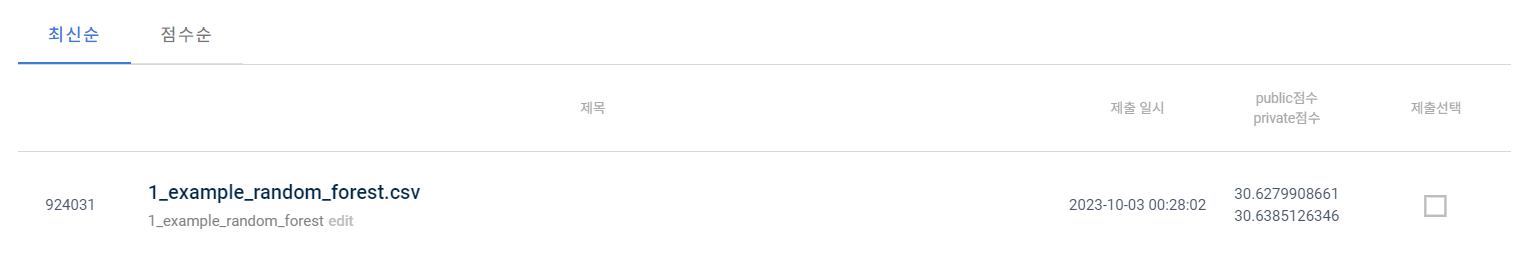